# PRÉPAREZ DES DONNÉES POUR UN ORGANISME DE SANTÉ PUBLIQUE

![](Logo-Sante-Publique-France-.png)

# Table des matières

xxxxxxxxxxxxxxxxxx à faire xxxxxxxxxxxxxxx

# Introduction

L'agence "Santé publique France" a lancé un **appel à projets pour rendre les données de santé plus accessibles**. L’agence souhaite faire explorer et visualiser des données, pour que ses agents puissent les exploiter.

Le jeu de données à analyser est issu de la plateforme **Open Food Facts**, qui est une association donnant accès à une base données de produits alimentaires :
- ouverte à tous
- où tout le monde peut contribuer

Dans le cadre de cet appel à projets, nous :
- proposerons une idée d'application
- mènerons à bien le nettoyage nécessaire à l'exploration des données
- explorerons les données traitées

# Partie 1 - Imports & Proposition d'application

## P1.1. Imports des librairies & du dataset

Commençons par importer les principales librairies dont nous aurons besoin :

In [1]:
import pandas as pd # to manipulate the dataset with dataframes
import numpy as np # for statistics and calculations

import matplotlib.pyplot as plt # for data visualisation
%matplotlib inline
import matplotlib.ticker as mtick # for format axis in percent %
import seaborn as sns # for data visualisation, with different proporties
import missingno as ms # for visualisation of missing data

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


## P1.2. Import du dataset

In [2]:
foodRaw=pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t',low_memory=False)

Nous pouvons regarder les dimensions du tableau généré :

In [3]:
print("Le tableau mis à disposition comporte ", foodRaw.shape[1], "variables et ", foodRaw.shape[0], "lignes / produits")

Le tableau mis à disposition comporte  162 variables et  320772 lignes / produits


Nous pouvons affihcer les premières lignes :

In [4]:
display(foodRaw.head())

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nous avons à disposition 4 types de variables :
- Les informations générales sur la fiche du produit : nom, date de modification, etc.
- Un ensemble de tags : catégorie du produit, localisation, origine, etc.
- Les ingrédients composant les produits et leurs additifs éventuels.
- Des informations nutritionnelles : 
    - quantité en grammes d’un nutriment pour 100 grammes du produit.
    - des scores nutritionnels (comme le nutriscore)

## P1.3. Proposition d'application

Afin d'aider à améliorer la santé de nos concitoyens, nous pourrions utiliser les données mises à notre disposition pour aider les malades et les médecins.

En effet, un des principaux maux du 21$^{ème}$ est la multiplications de maladies chroniques dans nos sociétés industrialisées. Mes maladies cardiovasculaires représentent **la dépense la plus importante** pour l'Assurance Maladie.

**Hypertension, Diabètes, Cholestérol, Obésites, etc.** : Toutes ses pathologies sont, à des degrès différents, liées au régime alimentaire des malades.

En plus des médicaments, les médecins prescrivent également un **régime alimentaire adapté** aux pathologies chroniques des patients affectés.

Mais devant le nombre de produits disponibles en grandes surfaces, chacun avec une étiquette nutritionnelle qui lui est propre, le patient peut se retrouver démuni au moment de faire ses choix.

**MyHealthScore** : Une application **proposée par le médecin** à son patient pour l'aider à adapter son régime alimentaire à sa (ou ses) pathologie(s).

L'idée :
- le médecin configure le **profil** de son patient :
    - données biométriques : sexe, age, poids, taille, etc.
    - pathologie(s) : hypertension, diabètes, cholestérol, obésité, autre
    
    
- le profil permet de créé un score nutritionnel **adapté au patient** : *MyHealthScore*
    - ce score est basé sur les **mêmes données** nutritionnelles que le Nutri-Score :
        - La valeur énergétique (KJ)
        - Les lipides (g)
        - Les acides gras saturés (g)
        - Les sucres (g)
        - Les protéines (g)
        - Le sodium (mg)
        - Les fibres (g)
        - Fruits, légumes, etc. (%)
        
   mais **personnalisé** pour le profil du patient.


- l'**application** pourrait fonctionner ainsi :
    - le patient **scanne / rentre une référence** d'un produit
    - l'application **lui délivre ensuite son MyHeathScore personnalisé** selon les informations renseignées par son médecin.

- chaque système ayant ses propres spécificités, l'application serait dans un premier temps destinée au système de santé **français**.


## P1.4. Réduction du champ d'étude : France

Comme expliqué plus haut, nous allons nous concentrer sur le France dans le cadre cette étude.



Le dataset comporte plusieurs colonnes contenant des informations sur le pays :

In [5]:
# create a list with "coutries" columns
countriesColNames = [col for col in foodRaw.columns if "countri" in col]
countriesColNames

['countries', 'countries_tags', 'countries_fr']

Avant d'en sélectionner une pour notre filtrage, regardons à quoi elles ressemblent :

In [6]:
foodRaw[countriesColNames].sample(10)

,countries,countries_tags,countries_fr
72193,US,en:united-states,États-Unis
87781,US,en:united-states,États-Unis
309357,Spain,en:spain,Espagne
263001,Deutschland,en:germany,Allemagne
106335,US,en:united-states,États-Unis
118345,US,en:united-states,États-Unis
117284,US,en:united-states,États-Unis
71451,US,en:united-states,États-Unis
4402,US,en:united-states,États-Unis
164244,US,en:united-states,États-Unis


Nous pouvons nous concentrer sur la colonne "countries_fr".

Regardons le nombre de valeurs manquantes pour ces trois colonnes :

In [7]:
foodRaw[countriesColNames].isna().sum()

countries         280
countries_tags    280
countries_fr      280
dtype: int64

Elles n'en contiennent. Si elle ne sont pas positionnées aux mêmes endroits, nous pouvons regarder si "countries" et "countries_tags" peuvent nous aider à imputer "countries_fr" :

In [8]:
# create a mask for rows where "countries_fr" is NaN and one of the others is not
maskCountries = (foodRaw.countries_fr.isna())&((foodRaw.countries_tags.notna())|(foodRaw.countries.notna()))

foodRaw[countriesColNames].loc[maskCountries]

,countries,countries_tags,countries_fr


Les autres colonnes ne peuvent donc pas nous aider à combler les 280 valeurs manquantes. Nous ne considérerons pas ces produits.

Regardons maintenant les différents pays contributeurs de la base de données :

In [9]:
# list of unique values in "countries_fr" and number of occurrences
foodRaw.countries_fr.value_counts(ascending=False)

États-Unis                                      172998
France                                           94392
Suisse                                           14953
Allemagne                                         7870
Espagne                                           5009
                                                 ...  
Danemark,Suisse,en:Deutschland,en:Frankreich         1
France,Luxembourg,Suisse                             1
Autriche,République tchèque,Allemagne                1
Allemagne,Hongrie                                    1
Chine,Hong Kong                                      1
Name: countries_fr, Length: 722, dtype: int64

Les valeurs de cette variable contiennent, en chaîne de caractères, la liste des pays où le produit est commercialisé.

Afin de nous concentrer sur la france, nous allons donc rechercher dans ces chaînes de caractères :

In [10]:
# create masks for french products 
maskFrance = foodRaw.countries_fr.str.find("France")!=-1
maskfrance = foodRaw.countries_fr.str.find("france")!=-1
maskFr = foodRaw.countries_fr.str.find("Fr")!=-1
maskFR = foodRaw.countries_fr.str.find("FR")!=-1
maskfr = foodRaw.countries_fr.str.find("fr")!=-1

Testons ces différents filtres.

In [11]:
foodRaw.loc[maskFrance,"countries_fr"].value_counts()

France                                                   94392
France,Suisse                                             1224
France,Royaume-Uni                                         514
Belgique,France                                            512
France,Allemagne                                           240
                                                         ...  
Belgique,France,Allemagne,Roumanie                           1
Australie,République tchèque,France,Allemagne,Hongrie        1
Danemark,France,Allemagne,Russie,Espagne,Royaume-Uni         1
République tchèque,Danemark,France,Allemagne                 1
France,Hong Kong                                             1
Name: countries_fr, Length: 305, dtype: int64

On obtient 305 valeurs uniques en recherchant avec "France". Continuons :

In [12]:
foodRaw.loc[maskfrance,"countries_fr"].value_counts()

Series([], Name: countries_fr, dtype: int64)

Cette orthographe n'est pas utilisée. Continuons :

In [13]:
foodRaw.loc[maskFr&~maskFrance,"countries_fr"].value_counts()

Suisse,Deutschland,Frankreich                                                                                                9
Suisse,Frankrijk,Nederland                                                                                                   2
Danemark,Suisse,es:Franciaorszag,es:Magyarorszag,es:Nagy-britannia,es:Portugalia,es:Spanyolorszag                            1
Belgique,Danemark,Suisse,es:Franciaorszag,es:Magyarorszag,es:Nagy-britannia,es:Nemetorszag,es:Portugalia,es:Spanyolorszag    1
Suisse,Deutschland,Frankreich,Spanien                                                                                        1
Suisse,Frankrijk                                                                                                             1
Suisse,Belgien,Deutschland,Frankreich                                                                                        1
Danemark,Suisse,en:Deutschland,en:Frankreich                                                                   

France est orthographié différemment.

In [14]:
foodRaw.loc[maskfr&~maskFrance,"countries_fr"].value_counts()

Polynésie française               52
Afrique du Sud                    36
en:fruit-yogurts                   8
Polynésie française,États-Unis     3
Polynésie française,Suisse         1
République centrafricaine          1
Name: countries_fr, dtype: int64

In [15]:
# create a mask for "Polynésie française"
maskPolyFr = foodRaw.countries_fr.str.find("Polynésie française")!=-1

In [16]:
foodRaw.loc[maskFR,"countries_fr"].value_counts()

Series([], Name: countries_fr, dtype: int64)

Ce dernier mask n'a rien donné. Nous pouvons donc filtrer notre dataframe pour ne conserver que les produits commercialisés en France : 

In [17]:
foodRawFr = foodRaw.copy()
#apply selected masks
foodRawFr = foodRawFr.loc[maskFrance|maskFr|maskPolyFr]

Voici les nouvelles dimensions du dataframe :

In [18]:
foodRawFr.shape

(98800, 162)

## P1.5. Sélection des variables

Pour fonctionner, l'application ferait appel à la base de données d'OpenFoodFact pour récupérer les données nutritionnelles et calculer le MyHealthScore du patient.

Il faut pour cela que les données soient présentes. Regardons visuellement le niveau de remplissage du dataset. Pour cela nous allons utiliser la librairie `missingno` :

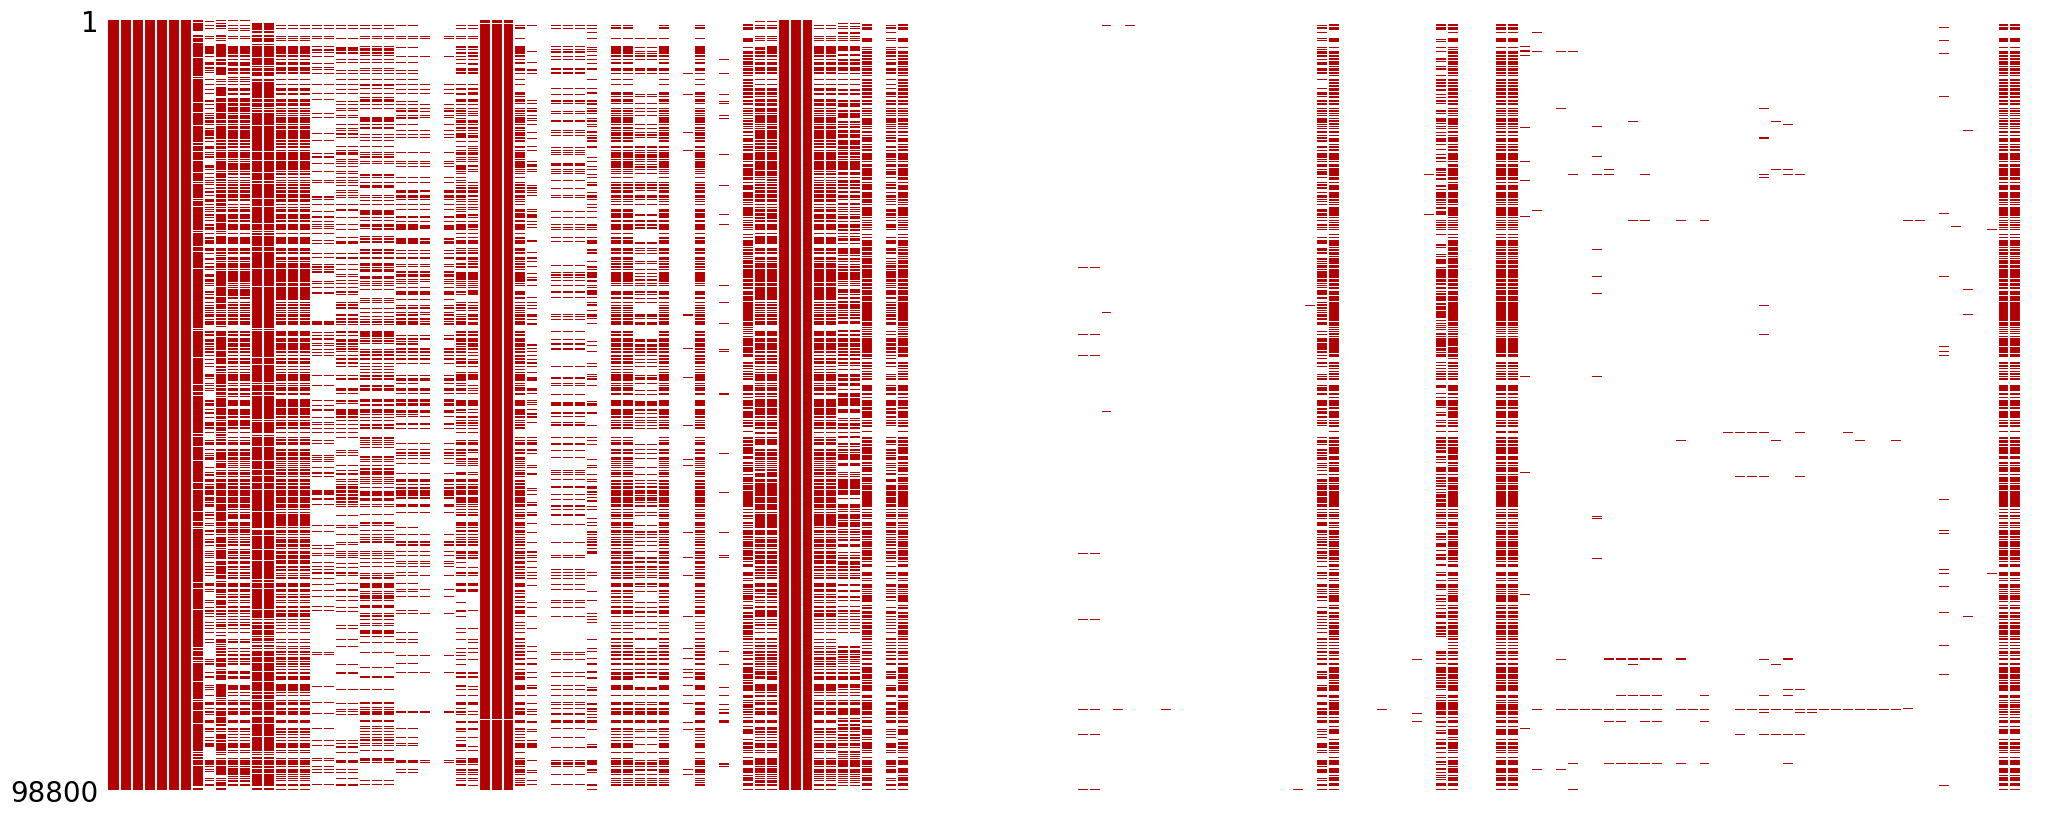

In [19]:
ms.matrix(foodRawFr,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.show()

Le dataset est globalement **très peu renseigné**.

Nous pouvons regarder ce qu'il en est des features qui nous intéressent pour calculer, théoriquement, un MyHealthScore :

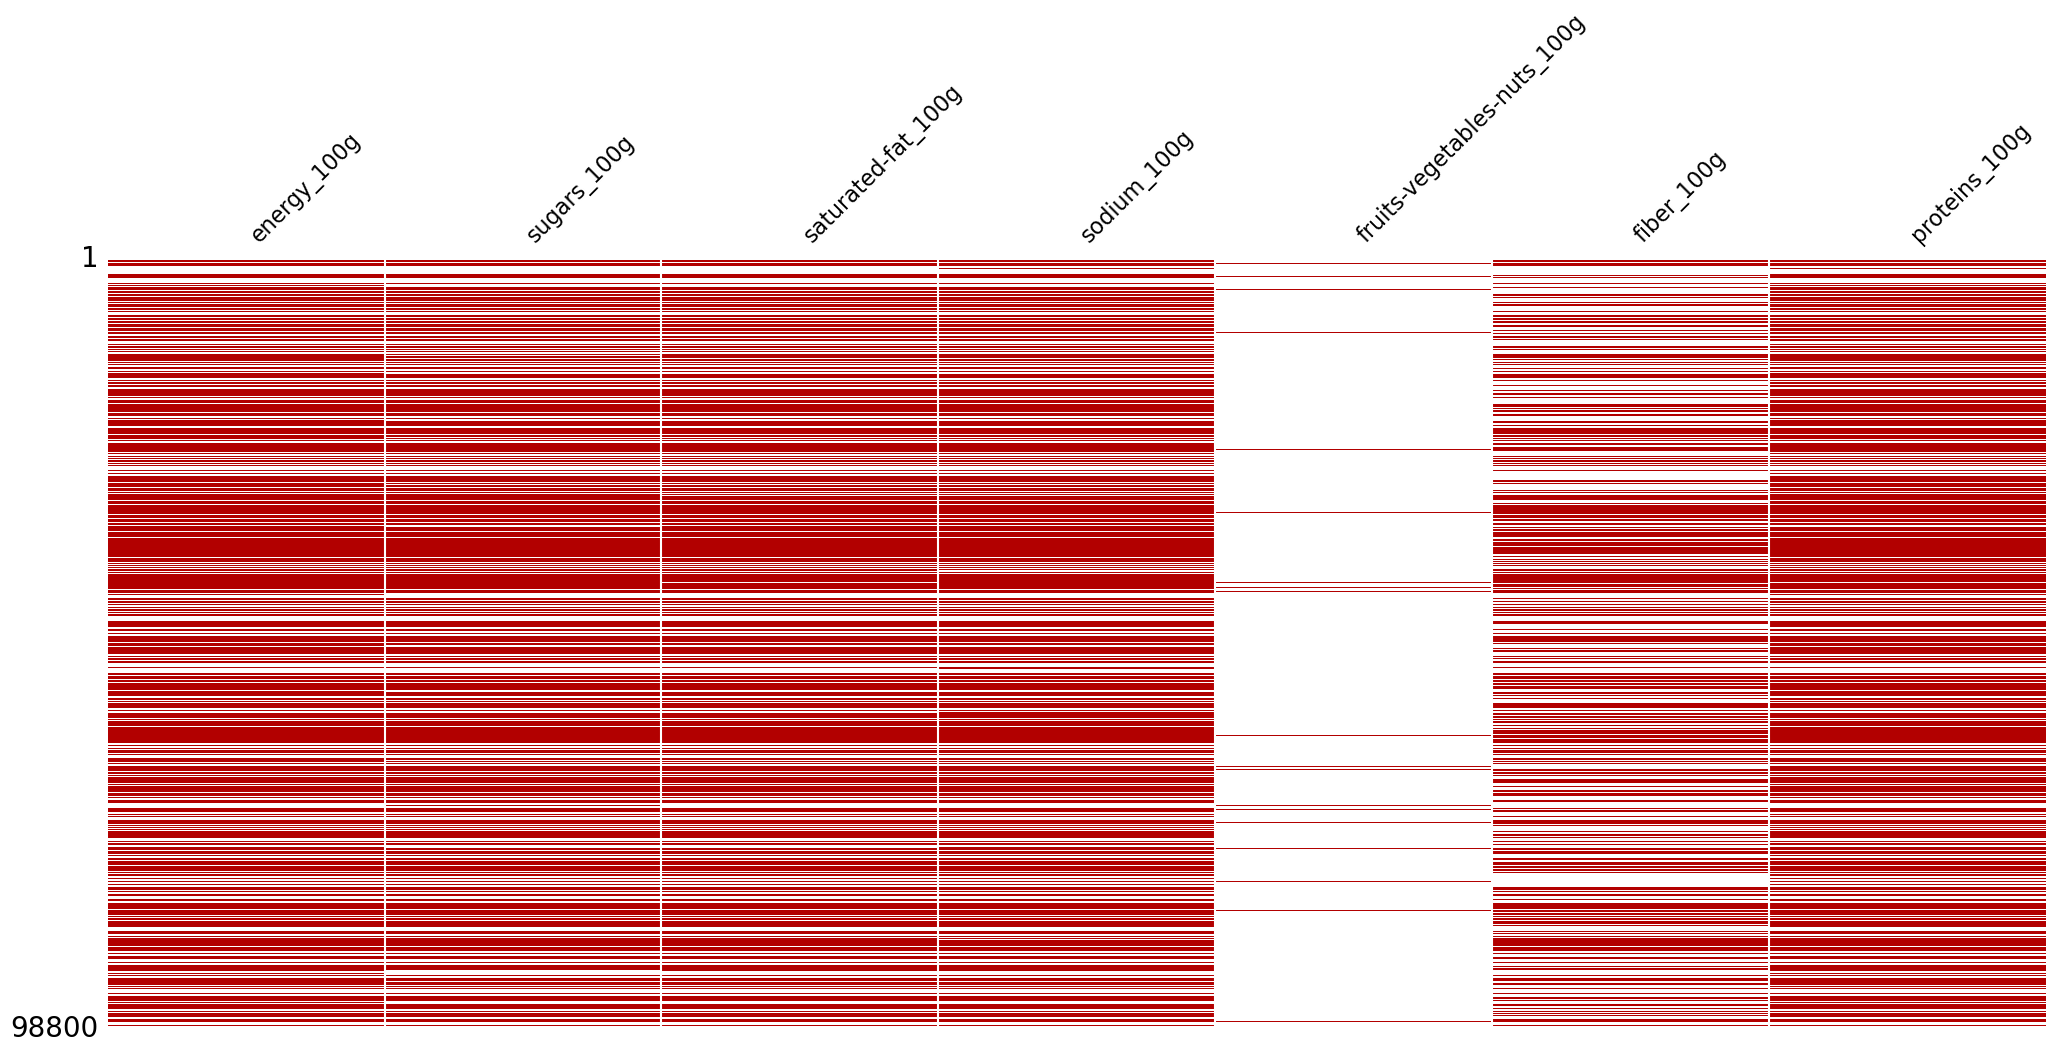

In [20]:
theoricalFeaturesNames=["energy_100g","sugars_100g","saturated-fat_100g","sodium_100g","fruits-vegetables-nuts_100g","fiber_100g","proteins_100g"]
ms.matrix(foodRawFr[theoricalFeaturesNames],color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.show()

Malheureusement la feature concernant les **fruits et légumes** est **très peu renseignée**...

Or celle-ci se révèle indispensable pour calculer un MyHealthScore reflétant correctement les recommandations médicales.

Par exemple, si l'on regarde les **préconisations hygiéno-ditétiques pour les personnes atteinte d'hypertension**, le site internet de la **CPAM indique** :
- sel : < 6g /j
- perdre du poids, soit via une IMC < 25 kg/m², soit en perdant 10% du poids initial
- activité physique, soit 30 min/j, soit 3x / semaine
- réduire consommation d'alcool
- augmenter la consommation de **fruits et légumes**
- réduire la consommation de graisses saturées
- arrêter le tabac

La construction d'un MyHealthScore devra donc passer par la prise en compte d'autres colonnes. Pour les déterminer, nous pourrons nous baser dans un premier temps sur le "taux de vide". Regardons ce que cela donne pour les colonnes `theoricalFeaturesNames` :

In [21]:
# percentage of null values in primal selected features :
(foodRawFr[theoricalFeaturesNames].isna().mean()*100).round(1).astype(str)+" %"

energy_100g                    34.5 %
sugars_100g                    36.6 %
saturated-fat_100g             36.8 %
sodium_100g                    36.6 %
fruits-vegetables-nuts_100g    97.0 %
fiber_100g                     53.7 %
proteins_100g                  34.8 %
dtype: object

Écrivons une fonction pour filtrer les colonnes en fonction de leur taux de valeurs manquantes :

In [22]:
def dropEmptyCols(df,emptinessThreshold=1) :
    
    """return an input pandas.DataFrame without its empty columns
    
    inputs
    ------
    df : pandas.DataFrame object
    
    optional inputs 
    ---------------
    emptinessThreshold : float, defaul : = 1. Gives the limit threshold of emptiness. 
    if >=threshold, column is dropped. 
    
    returns
    -------
    dfWithoutEmptyCols : pandas.DataFrame object, the same one without its empty columns
    
    """
    #select columns with percentage of null values > threshold
    emptyColsNames=df.isna().mean().loc[df.isna().mean()>=emptinessThreshold].index 
    
    #drop selected columns
    dfWithoutEmptyCols=df.copy()
    dfWithoutEmptyCols = dfWithoutEmptyCols.drop(columns=emptyColsNames)
    
    return dfWithoutEmptyCols

Nous avons d'ores et déjà fait une croix sur `fruits-vegetables-nuts_100g`. Basons-nous sur le taux de `fiber_100g` :

In [23]:
foodWithout_54=dropEmptyCols(foodRawFr,emptinessThreshold=0.54)

In [24]:
# check percentage of null values in foodWithout_54
(foodWithout_54.isna().mean().sort_values()*100).round(2).astype(str)+" %"

code                                         0.0 %
url                                          0.0 %
creator                                      0.0 %
created_t                                    0.0 %
last_modified_t                              0.0 %
last_modified_datetime                       0.0 %
created_datetime                             0.0 %
states                                      0.02 %
states_tags                                 0.02 %
states_fr                                   0.02 %
countries                                   0.28 %
countries_tags                              0.28 %
countries_fr                                0.28 %
product_name                                7.36 %
brands                                     12.29 %
brands_tags                                 12.3 %
quantity                                   27.66 %
pnns_groups_2                              31.95 %
pnns_groups_1                              34.14 %
energy_100g                    

N'ayant pas à notre disposition la teneur en fruits et légumes, nous pouvons nous baser sur le Nutri-Score, qui prend en compte celle-ci dans son calcul.

A partir du Nutri-Score, il sera possible dans le cadre du développement de l'application, de créer un MyHealthScore en adaptant les pondérations des autres valeurs nutritionnelles.

On peut donc sélectionner les variables suivantes pour notre analyse :
- `code`, `product_name` et `brands` pour identitifer les produits
- `nutrition-score-fr_100g` qui correspond au socre nutritionnel
- `nutrition_grade_fr` qui correspond au Nutri-Score, l'échelle graphique scindant le score nutritionnel en 5 classes A, B, C, D et E
- `energy_100g`
- `proteins_100g`
- `fiber_100g`
- `sodium_100g` et `salt_100g`, ("salt" est liée à "sodium" par un facteur 2.5. Nous nous servirons de cette variable pour un traitement en particulier, puis nous l'écarterons) 
- `sugars_100g` et `carbohydrates_100g`
- `saturated-fat_100g` et `fat_100g`
- `pnns_groups_2` et `pnns_groups_1` qui permettent de classifier les produits dans des catégories plus ou moins précises

In [25]:
# select work features
workFeatures=["code",
               "product_name",
               "brands",
               "pnns_groups_1",
               "pnns_groups_2",
               "nutrition-score-fr_100g",
               "nutrition_grade_fr",
               "salt_100g",
               "carbohydrates_100g",
               "fat_100g"]+theoricalFeaturesNames
workFeatures.remove("fruits-vegetables-nuts_100g")

In [26]:
foodRawLight = foodRawFr.copy()
foodRawLight = foodRawLight[workFeatures]
foodRawLight

,code,product_name,brands,pnns_groups_1,pnns_groups_2,nutrition-score-fr_100g,nutrition_grade_fr,salt_100g,carbohydrates_100g,fat_100g,energy_100g,sugars_100g,saturated-fat_100g,sodium_100g,fiber_100g,proteins_100g
0,0000000003087,Farine de blé noir,Ferme t'y R'nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,0000000024600,Filet de bœuf,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,0000000027205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,0000000036252,Lion Peanut x2,Sunridge,unknown,unknown,22.0,e,0.09652,70.0,20.0,1883.0,57.5,12.5,0.038,2.5,2.5
136,0000000039259,Twix x2,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320761,9906410000009,Roussette du Bugey (2011),Roussette du Bugey,NaN,Alcoholic beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320763,99111250,Thé vert Earl grey,Lobodis,Beverages,Non-sugared beverages,2.0,c,0.02540,0.5,0.2,21.0,0.5,0.2,0.010,0.2,0.5
320764,9918,"Cheese cake thé vert, yuzu",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320765,9935010000003,Rillette d'oie,"Sans marque,D.Lambert",Fish Meat Eggs,Processed meat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On peut afficher de nouveau la visualisation des valeurs manquantes :

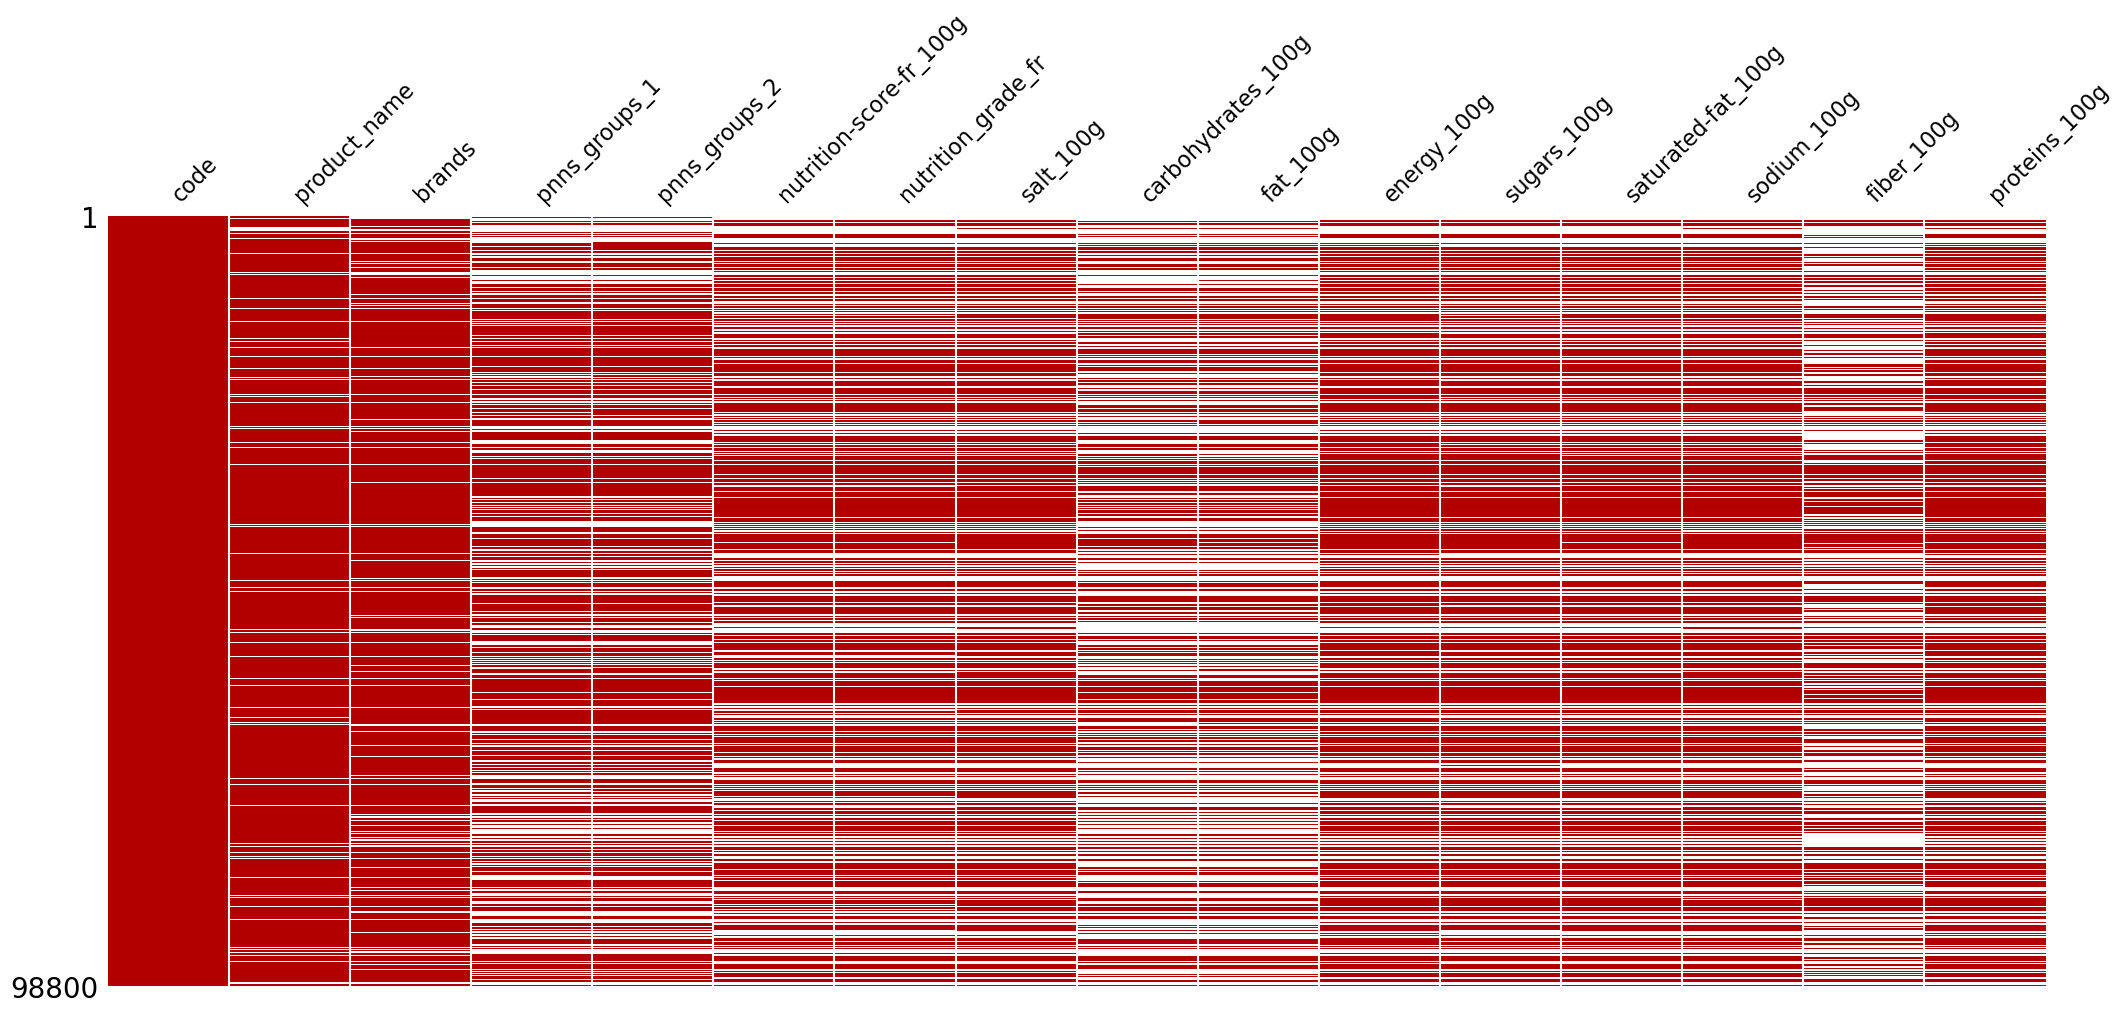

In [27]:
ms.matrix(foodRawLight,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.show()

# Partie 2 - Nettoyage

## P2.1. Nommage des colonnes

Pour faciliter le traitement, nous renommons certaines colonnes pour supprimer les "-" et les remplacer par des "_" :

In [28]:
# use only underscore for column names

foodRawLightUnder=foodRawLight.copy() # create a copy
foodRawLightUnder.rename(columns={col : col.replace("-","_") for col in foodRawLightUnder.columns}, # replace "-" by "_"
                         inplace=True
                        )
workFeatures=foodRawLightUnder.columns.tolist()

## P2.2. Éliminer les doublons

Pour repérer les produit présents deux fois, nous pouvons dans un premier temps regarder la colonne "code".

### P2.2.1. Des produits en double ? "code"

In [29]:
foodRawLightUnder.code.sample(5)

219234    3270160642281
205314    3250390139577
225456    3329770053465
274694    5060191280433
259065    4008452027602
Name: code, dtype: object

le format du code à l'air d'être une suite de 13 chiffres.
Cependant le type "object" de la Series interroge.

In [30]:
# looking to the lenght of "code" values for formatting issues
foodRawLightUnder.code.str.len().value_counts(dropna=False).sort_index()

1         2
2         1
3         2
4         6
5        10
6        32
7        38
8      6186
9         6
10       33
11       30
12       36
13    92329
14       51
15       23
16        3
17        1
22        1
24        4
25        1
31        1
32        2
40        1
41        1
Name: code, dtype: int64

Après quelques recherches, les deux formats les plus représentés correspondent aux systèmes EAN 8 et EAN 13 (EAN pour *European Article Numbering*). Ces deux systèmes sont les plus utilisés en Europe.

Nous faisons le choix de nous séparer des 285 produits aux codes barres non formatés EAN 8 ou 13 : l'usage principal du MyHealthScore se fera via l'application et le scan de code barre.

In [31]:
foodClean01=foodRawLightUnder.copy()
# keep only the values of "code" whose length is 8 or 13
foodClean01=foodClean01.loc[(foodClean01.code.str.len()==8)|(foodClean01.code.str.len()==13)]

Nous pouvons maintenant regarder s'il y a des produits en double :

In [32]:
#look for duplicates in column "code"
foodClean01.loc[foodClean01.code.duplicated(keep=False)]

,code,product_name,brands,pnns_groups_1,pnns_groups_2,nutrition_score_fr_100g,nutrition_grade_fr,salt_100g,carbohydrates_100g,fat_100g,energy_100g,sugars_100g,saturated_fat_100g,sodium_100g,fiber_100g,proteins_100g


Il ne semble pas y avoir de produits différents utilisant le même code-barre.

Une autre manière de repérer les doublons et de regarder la colonne "product_name".

### P2.2.2. Des produits en double ? "product_name" 

Nous n'avons que des produits au code-barre unique. Mais le même produit a pu être étiqueté avec 2 code-barres différents. Regardons.

In [33]:
foodClean01.product_name.value_counts()

Huile d'olive vierge extra        62
Mayonnaise                        54
Moutarde de Dijon                 49
Orange                            46
Spaghetti                         46
                                  ..
3 Œufs avec surprise               1
20 saucisses de Strasbourg         1
Gelée extra Mûre                   1
noir Eclats de fèves 72% cacao     1
Tomates aux Vermicelles            1
Name: product_name, Length: 74413, dtype: int64

Nous ne sommes pas assez précis. Nous ne pouvons pas considérer seulement "product_name" pour rechercher les doublons. Regardons également "brands".

### P2.2.3. Des produits en double ? "product_name" ET "brands"

Regardons si des noms de produits sont présents plusieurs fois sous la même marque :

In [34]:
# look in non null values for "product_name","brands" and "code" for products with the same name and brand :
foodClean01[["product_name","brands",'code']].loc[foodClean01[["product_name","brands",'code']].notna().all(axis=1)].groupby(['product_name',"brands"]).count().sort_values("code",ascending=False).head(10)

,,code
product_name,brands,
Coca-Cola,Coca-Cola,20
Pom'potes,Materne,15
Nutella,"Ferrero,Nutella",14
Orangina,Orangina,14
Nesquik,"Nestlé,Nesquik",11
Perrier,Perrier,11
Auchan,Auchan,10
Nutella,Ferrero,10
Mousline,Maggi,9


Il y a donc des doublons. Ceux-ci peuvent être expliqués par :
- un même produit rentré plusieurs fois sous des codes différents
- un même produit avec des quantités différentes (un pack de 6 bouteilles versus une bouteille seule)

Le score n'a pas vocation à prendre en compte la quantité. Ce sont les qualités intrinsèques du produit, pour 100g en l'occurrence, qui nous intéressent.

Nous allons donc supprimer ces doublons.

In [35]:
foodClean02=foodClean01.copy()
foodClean02=foodClean02.loc[
    (foodClean02[["product_name","brands"]].isna().any(axis=1)) # be carefull to keep the rows where "product_name" or "brands" is NaN
    | # or :
    ~(foodClean02[["product_name","brands"]].duplicated(subset=["product_name","brands"],keep='last')) # non duplicated values for both features
]

In [36]:
print("On a retiré ",foodClean01.shape[0]-foodClean02.shape[0]," produits considérés comme doublons")

On a retiré  3105  produits considérés comme doublons


## P2.3. Traiter les outliers

On sait que les outliers ont un impact négatif sur la moyenne et l'écart type empiriques de nos variables. Avant de nous concentrer sur l'imputation des valeurs manquantes, il faut d'abord traiter ces outliers. Regardons dans un premiers temps les valeurs min et max des variables numériques :

In [37]:
foodClean02.describe()

,nutrition_score_fr_100g,salt_100g,carbohydrates_100g,fat_100g,energy_100g,sugars_100g,saturated_fat_100g,sodium_100g,fiber_100g,proteins_100g
count,59076.000000,60197.000000,45154.000000,45585.000000,6.215600e+04,60145.000000,60007.000000,60194.000000,44059.000000,61881.000000
mean,8.676366,1.162005,27.839665,13.293629,1.174376e+03,13.396842,5.451226,0.457503,2.576606,7.787648
std,9.038369,4.261100,27.348395,16.752498,1.308400e+04,19.010655,8.554641,1.677578,4.682310,7.889584
min,-15.000000,0.000000,0.000000,0.000000,0.000000e+00,-0.100000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.080000,4.100000,1.400000,4.310000e+02,1.000000,0.300000,0.031496,0.000000,1.900000
50%,9.000000,0.560000,14.900000,7.000000,1.037000e+03,4.000000,2.000000,0.220472,1.400000,6.000000
75%,15.000000,1.250000,53.000000,21.000000,1.648000e+03,17.860000,7.500000,0.492126,3.200000,11.000000
max,40.000000,211.000000,190.000000,380.000000,3.251373e+06,105.000000,210.000000,83.000000,178.000000,100.000000


On peut remarquer que :
- il y a des valeurs **négatives** pour les features "nutrition_score_fr_100g", ce qui est normal, et pour **"sugars_100g"**, ce qui devra être traîté
- les valeurs maximales pour les valeurs nutritionnelles " *..._100g* " classiques (hors score nutritionnel et énergie) comportent des irrégularités car **certaines sont supérieures à 100g**...
- après quelques recherches, la quantité maximale d'énergie pour 1g est de 37 kJ/g. Donc théoriquement les valeurs de la colonne **"energy_100g" ne peuvent pas dépasser 3700**, là où le maximum est de 3 251 373... L'écart-type est du coup vraiment impacté : 13084...

Pour la suite de l'étude, on passera la plupart de ces valeurs en valeur manquante.

D'autres opérations de nettoyage seront également menées, cette fois basées sur le contexte métier.

### P2.3.1. Masse de sucre négative


In [38]:
# replace negative "sugars_100g" with null values 

foodClean03=foodClean02.copy()
foodClean03.loc[foodClean03.sugars_100g<0,"sugars_100g"]=np.nan

In [39]:
print("On a traité ",((foodClean03.notna())!=(foodClean02.notna())).sum().sum()," produit dont le poids en sucre était négatif")

On a traité  1  produit dont le poids en sucre était négatif


### P2.3.2. Poids des constituants pour 100g supérieurs à 100g 


Sélectionnons tout d'abord les features à traiter :

In [40]:
# first, look a columns types
foodClean03.dtypes.unique()

array([dtype('O'), dtype('float64')], dtype=object)

In [41]:
# select numerical columns
componentFeatures=foodClean03.select_dtypes("float64").columns.tolist()
componentFeatures

['nutrition_score_fr_100g',
 'salt_100g',
 'carbohydrates_100g',
 'fat_100g',
 'energy_100g',
 'sugars_100g',
 'saturated_fat_100g',
 'sodium_100g',
 'fiber_100g',
 'proteins_100g']

In [42]:
# exclude "non component" columns
componentFeatures.remove("nutrition_score_fr_100g")
componentFeatures.remove("energy_100g")

In [43]:
# search for "..._100g" > 100
foodClean04=foodClean03.copy()
foodClean04.loc[(foodClean04[componentFeatures]>100).any(axis=1),componentFeatures]

,salt_100g,carbohydrates_100g,fat_100g,sugars_100g,saturated_fat_100g,sodium_100g,fiber_100g,proteins_100g
155609,NaN,164.0,0.0,72.7,0.00,NaN,NaN,0.0
202571,0.14000,104.0,0.0,104.0,0.00,0.055100,0.000,0.0
232239,211.00000,47.8,23.0,26.7,3.33,83.000000,0.741,6.3
233372,125.00000,0.0,0.0,0.0,0.00,49.212598,0.000,0.0
234726,1.30048,106.0,52.0,52.0,35.50,0.512000,3.000,10.0
239347,NaN,105.0,NaN,105.0,NaN,NaN,NaN,NaN
245311,9.33000,190.0,380.0,22.7,210.00,3.670000,0.000,0.0
260599,0.10000,103.5,1.0,103.5,0.10,0.039370,NaN,1.0
298897,0.37000,59.0,29.0,58.0,18.00,0.145669,178.000,6.3
305054,0.01000,70.0,105.0,2.5,0.30,0.003937,NaN,12.0


In [44]:
# replace "..._100g" > 100 with null value
foodClean04[componentFeatures]=foodClean04[componentFeatures].mask(foodClean04[componentFeatures]>100,np.nan)

In [45]:
print("On a passé en valeur manquante ",((foodClean03.notna())!=(foodClean04.notna())).sum().sum()," masses qui étaient supérieures à 100g")

On a passé en valeur manquante  18  masses qui étaient supérieures à 100g


### P2.3.3. Énergie pour 100g supérieure à 3700 kJ.


In [46]:
# search products with energy_100g > 3700

foodClean05=foodClean04.copy()
foodClean05.loc[(foodClean05.energy_100g>3700),["product_name","energy_100g"]].sort_values("energy_100g").sample(15)

,product_name,energy_100g
211408,Mélange 4 Huiles Végétales,3766.0
194542,Pignon de pin,3707.0
223315,Huile De Sésame Grillé,3766.0
251321,Sardines à l'huile d'olive,3833.0
223348,Huile vierge biologique Chanvre,3766.0
234016,50CL HUILE D'OLIVE FRUITEE Espagne,3766.0
249617,Huile Argan,3766.0
240117,Huile d'olive,3766.0
244929,Spéciale pizza,3766.0
271532,Pure coconut oil,3761.0


Les produits en question semblent être majoritairement des huiles. Après quelques recherches, on sait que ces produits ont une valeur énergétique de 900 kcal (3700 kJ). On va donc appliquer deux traitement différents :
- imputer à 3700 pour les produits dont le nom contient "huile"
- imputer à NaN pour les autres produits concernés

In [47]:
# mask for "energy_100g" > 3700 and product is an oil
above3700andOilMask = ((foodClean05.energy_100g>3700)
                &(foodClean05.product_name.notna())
                &(
                    (foodClean05.product_name.str.find("Huile")!=-1) 
                    |(foodClean05.product_name.str.find("huile")!=-1) 
                    |(foodClean05.product_name.str.find(" Oil ")!=-1) 
                    |(foodClean05.product_name.str.find(" oil ")!=-1)
                )
               )

In [48]:
# replace "energy_100g" with 3700
foodClean05.loc[above3700andOilMask,"energy_100g"]=3700

In [49]:
(foodClean04.loc[foodClean04.energy_100g.notna(),"energy_100g"]!=foodClean05.loc[foodClean05.energy_100g.notna(),"energy_100g"]).sum()

131

In [50]:
print("On a passé à 3700 kJ ",above3700andOilMask.sum()," valeurs énergétiques d'huiles qui étaient supérieures à 3700 kJ")

On a passé à 3700 kJ  131  valeurs énergétiques d'huiles qui étaient supérieures à 3700 kJ


In [51]:
foodClean05.loc[(foodClean05.energy_100g>3700),"energy_100g"]=np.nan

In [52]:
print("On a passé à valeur manquante ",((foodClean04.notna())!=(foodClean05.notna())).sum().sum()," valeurs énergétiques restantes, qui étaient supérieures à 3700 kJ")

On a passé à valeur manquante  123  valeurs énergétiques restantes, qui étaient supérieures à 3700 kJ


### P2.3.4. Sommes des masses des constituants PRINCIPAUX VS 100g

On peut aussi s'interroger sur les constituants dans leur ensemble. En effet, la somme des différents constituants "..._100g" ne devrait pas faire plus de 100g.

La question est de savoir quels constituants sommer. En effet certains sont des sous-produits d'autres constituants...

Après un peu de recherche (source https://ciqual.anses.fr/#/cms/questions-reponses/node/23), les "macro-constituants", dont la somme est censée être égale à 100, sont les suivant : **protéines, glucides totaux, lipides, alcool, cendres et eau**. Balayons ces différents éléments :

- proteins_100g : ok
- carbohydrates_100g : ok
- fat_100g : ok
- alcohol_100g : a été retiré du dataframe... Nous pouvons le réintégrer provisoirement
- cendres : correspondent au minéraux. Il ne nous reste que le sodium (sel)
- eau : ne fait pas partie de nos données

Nous allons nous concentrer sur les composants principaux à notre disposition. **Si la somme de ces masses est supérieure à 100g, et ce même sans les informations manquantes (on pense notamment à l'eau), alors nous écarterons le produit en question.**

In [53]:
# main nutrients column names 
macroNutCols=[
    'alcohol_100g',
    'proteins_100g',
    'carbohydrates_100g',
    'fat_100g',
    'salt_100g'
]

# create a dataframe with "alcohol_100g" back in
foodClean_WithAlcohol=foodClean05.copy()
foodClean_WithAlcohol['alcohol_100g']=foodRaw.loc[foodClean_WithAlcohol.index,"alcohol_100g"]

In [54]:
# compute the sum and put it in a Series

foodClean_WithAlcohol["sumOfMacro"]=foodClean_WithAlcohol[macroNutCols].sum(axis=1)
foodClean_WithAlcohol["sumOfMacro"]

0          0.00000
46         0.00000
48         0.00000
106       92.59652
136        0.00000
            ...   
320760     0.00000
320761    12.00000
320763     1.22540
320765     0.00000
320770     0.00000
Name: sumOfMacro, Length: 95410, dtype: float64

In [55]:
# create au mask for "sumOfMacro" > 100
mask_MacroAbove100=foodClean_WithAlcohol["sumOfMacro"]>100
# look a concerned products
foodClean_WithAlcohol.loc[mask_MacroAbove100,macroNutCols+["sumOfMacro"]].sort_values("sumOfMacro")

,alcohol_100g,proteins_100g,carbohydrates_100g,fat_100g,salt_100g,sumOfMacro
204888,0.0,0.00,0.0,100.0,0.00254,100.00254
184775,NaN,0.50,99.0,0.5,0.01000,100.01000
315944,NaN,0.50,99.0,0.5,0.01000,100.01000
210332,NaN,0.02,0.0,100.0,0.00000,100.02000
223303,NaN,0.00,0.0,100.0,0.02500,100.02500
...,...,...,...,...,...,...
285429,NaN,100.00,NaN,NaN,50.00000,150.00000
177924,NaN,5.40,69.4,87.0,0.38000,162.18000
197179,NaN,48.10,97.7,21.9,NaN,167.70000
286048,NaN,90.00,49.0,39.0,0.01000,178.01000


Certaines sommes >100 ne le sont que très légèrement.

Nous allons donc :
- fixer un seuil sur la somme en deça duquel nous corrigerons les masses
- remplacer les masses par nan si la sommes au dessus du seuil

In [56]:
# create a 5% threshold for "sumOfMacro"
above100Threshold = 100*1.05

# create a mask
maskUnderThreshold = foodClean_WithAlcohol["sumOfMacro"]<above100Threshold

# keep the concerned index
indexUnderThreshold=foodClean_WithAlcohol.loc[mask_MacroAbove100&maskUnderThreshold,macroNutCols+["sumOfMacro"]].index

# adjust the "..._100g" values so the sum is under 100
foodClean06=foodClean05.copy() # create copy
macroNutCols.remove('alcohol_100g') # remove 'alcohol_100g' from the macroNutCols list
foodClean06.loc[indexUnderThreshold,macroNutCols]=foodClean06.loc[indexUnderThreshold,macroNutCols].multiply(100/foodClean_WithAlcohol.loc[indexUnderThreshold,"sumOfMacro"],axis=0)

In [57]:
print("On a ajusté les masses des composants principaux de ",len(indexUnderThreshold)," produits afin que leur somme ne dépasse pas 100g")

On a ajusté les masses des composants principaux de  86  produits afin que leur somme ne dépasse pas 100g


In [58]:
# for sums above threshold, replace ".._100g" values with np.nan

# find the index
indexAboveThreshold = foodClean_WithAlcohol.loc[mask_MacroAbove100&(~maskUnderThreshold),macroNutCols+["sumOfMacro"]].index

# replace the "..._100g" values with np.nan
foodClean06.loc[indexAboveThreshold,macroNutCols]=np.nan

In [59]:
print("On a passé à valeur manquante ",((foodClean05.notna())!=(foodClean06.notna())).sum().sum()," masses restantes, dont la somme dépassait le seuil fixé")

On a passé à valeur manquante  164  masses restantes, dont la somme dépassait le seuil fixé


Maintenant que nous avons utilisé "Salt_100g", **nous pouvons nous en séparer**. Vérifions tout de même elle pourrait servir à imputer "sodium_100g" :

In [60]:
# check if there are products with null values for "salt" and non-null value for "sodium", and vice versa
foodSaltOrSodium=foodClean06[["salt_100g","sodium_100g"]].loc[(foodClean06.salt_100g.notna())^(foodClean06.sodium_100g.notna())]
foodSaltOrSodium

,salt_100g,sodium_100g
150141,NaN,0.262000
163139,NaN,33.300000
176060,NaN,1.893701
177924,NaN,0.149606
186936,NaN,0.007874
187827,NaN,6.610000
192024,NaN,0.007874
192840,0.1016,NaN
193253,NaN,11.811024
196636,NaN,0.748031


Il n'y a que trois valeurs. Imputons-les tout rapidement :

In [61]:
# impute these 3 "sodium_100g" null values with "salt_100g"  divided by 2.5
foodClean06.loc[foodSaltOrSodium.index,"sodium_100g"]=foodClean06.loc[foodSaltOrSodium.index,"salt_100g"]/2.5

foodClean06.loc[foodSaltOrSodium.index][["sodium_100g","salt_100g"]]

,sodium_100g,salt_100g
150141,NaN,NaN
163139,NaN,NaN
176060,NaN,NaN
177924,NaN,NaN
186936,NaN,NaN
187827,NaN,NaN
192024,NaN,NaN
192840,0.04064,0.1016
193253,NaN,NaN
196636,NaN,NaN


In [62]:
# remove "salt_100g"
workFeatures.remove("salt_100g")

In [63]:
foodClean06=foodClean06[workFeatures]

### P2.3.5. Masse d'un sous-composant > macro-composant

Sur le même principe, un sous-produit ne devrait pas avoir une masse supérieure à celle du produit principal.

Si l'on se concentre sur nos features, voici les comparaisons à mener :
- "sugars_100g" > "carbohydrates_100g"
- "saturated_fat_100g" > "fat_100g"

In [64]:
# create masks with subcomponent > main component

thresholdRate=1.10
mask_SatfatAboveFat=(
    (foodClean06['saturated_fat_100g']>foodClean06["fat_100g"]*thresholdRate)
     &(foodClean06["fat_100g"].notna())
)
    

mask_SugarAboveCarbo=(
    (foodClean06['sugars_100g']>foodClean06['carbohydrates_100g']*thresholdRate)
    &(foodClean06['carbohydrates_100g'].notna())
)

In [65]:
foodClean06.loc[mask_SatfatAboveFat,['saturated_fat_100g',"fat_100g","product_name"]]

,saturated_fat_100g,fat_100g,product_name
6570,1.0,0.0,Algues Wakame Pour Soupe Ou Salade WEL-PAC 56.7G
54995,15.0,5.0,Malt O Meal Cereal Coco Roos 23.
57332,0.9,0.0,Mae Ploy Chilli Sauce Sweet For Chicken - 25fl...
59062,0.1,0.0,Vinaigre Pour Sushi
99205,0.1,0.0,Panda Brand Oyster Sauce
...,...,...,...
302974,0.5,0.3,Tic Tac - Menthe
303082,0.5,0.0,Tic Tac Menthe
305772,1.6,0.0,Buongrano
315953,0.1,0.0,"Lipton Alps 20X1.1 GR, 1 Boîte"


In [66]:
foodClean06.loc[mask_SugarAboveCarbo,['sugars_100g',"carbohydrates_100g","product_name"]]

,sugars_100g,carbohydrates_100g,product_name
149836,15.0,6.25,Alo exposed
177460,48.6,7.05,"Favorina, Haselnuss Nougat Eier"
178306,3.9,3.50,Fromage blanc 20 % nature
178588,2.2,1.72,Foie gras de canard entier
179979,3.0,2.00,Chèvre frais
...,...,...,...
305772,20.5,0.00,Buongrano
310167,0.3,0.10,Chiffonade
312063,2.0,1.60,Filets d'anchois à l'huile d'olive
315480,26.0,23.00,Ben & Jerry's - Fairly Nuts


In [67]:
# replace values with NaN
foodClean07=foodClean06.copy()
foodClean07.loc[mask_SatfatAboveFat,["fat_100g"]]=np.nan
foodClean07.loc[mask_SugarAboveCarbo,['carbohydrates_100g']]=np.nan

In [68]:
print("On a passé à valeur manquante ",((foodClean07.notna())!=(foodClean06.notna())).sum().sum()," masses de composants incohérentes entre elles")

On a passé à valeur manquante  140  masses de composants incohérentes entre elles


### P2.3.6. Traitement des outliers, impact sur la moyenne et l'écart-type

La moyenne est l'écart-type sont sensibles aux outliers. Nous pouvons regarder si les traitements précédents ont eu un effet positif.

Pour cela nous allons étudier l'évolution de ces statistiques au fil des étapes de nettoyage.

In [69]:
# put the different foodClean## in a list
listFoodCleanDfs = [
    foodClean02,
    foodClean03,
    foodClean04,
    foodClean05,
    foodClean06,
    foodClean07
]

# list of names of numerical features
numericalFeatureNames=foodClean07.select_dtypes("float64").columns.tolist()
numericalFeatureNames.remove("energy_100g")
numericalFeatureNames.remove("sodium_100g")
numericalFeatureNames.append("sodium_100g")
numericalFeatureNames.append("energy_100g")
# put "sodium_100g" and "energy_100g" at the end of the list

# list of lists to store the empirical means of each numerical feature, for each cleaned dataframe
listOfMeans=[
    [listFoodCleanDfs[i][col].mean() for col in  numericalFeatureNames] 
    for i in range(len(listFoodCleanDfs))
]

# list of lists to store the empirical stds of each numerical feature, for each cleaned dataframe
listOfStds=[
    [listFoodCleanDfs[i][col].std(ddof=1) for col in  numericalFeatureNames] 
    for i in range(len(listFoodCleanDfs))
] 

In [70]:
# lists to store the evolution between each cleaning stage
listEvolOfStd=[
    [(listOfStds[i+1][idxcol]-listOfStds[i][idxcol])/listOfStds[i][idxcol] for idxcol in range(len(numericalFeatureNames))] 
    for i in range(len(listFoodCleanDfs)-1)
]

listEvolOfMean=[
    [(listOfMeans[i+1][idxcol]-listOfMeans[i][idxcol])/listOfMeans[i][idxcol] for idxcol in range(len(numericalFeatureNames))] 
    for i in range(len(listOfMeans)-1)
]

# cum sum
cumSumEvolOfStd=np.cumsum(listEvolOfStd,axis=0)
cumSumEvolOfMean=np.cumsum(listEvolOfMean,axis=0)

Pour une meilleure interprétation, nous allons représenter ces évolutions sur des graphiques :

In [71]:
sns.color_palette("Paired")[4]

(0.984313725490196, 0.6039215686274509, 0.6)

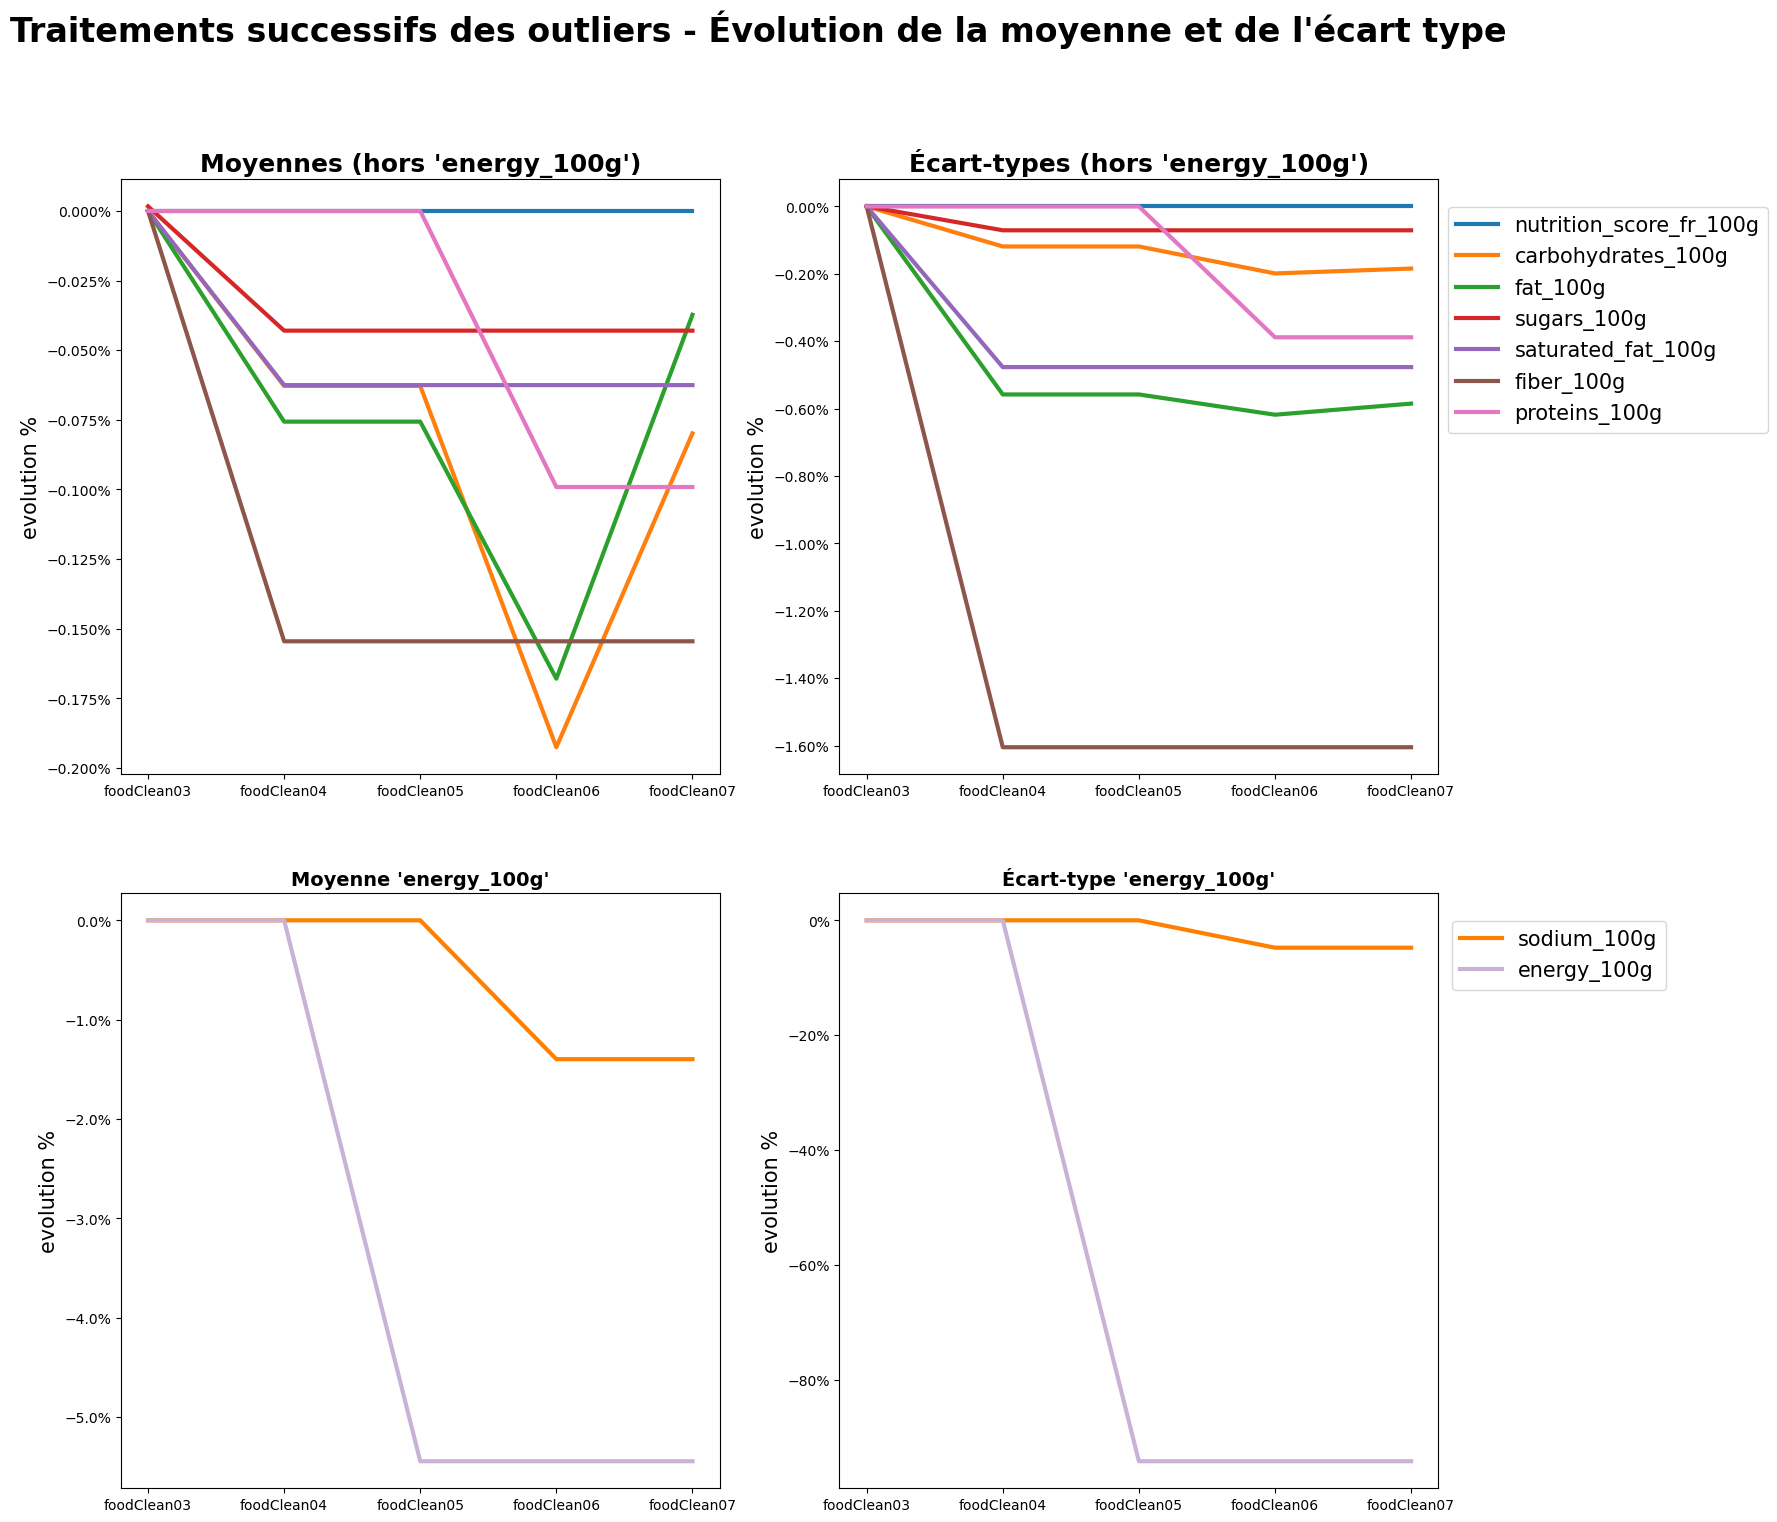

In [72]:
# visualisations of empirical mean and std evolution for each cleaning stage

palette=sns.color_palette("Paired") # set color palette
fig,axs=plt.subplots(2,2,sharex=False,figsize=(17,17)) # 4 plots 

axs=axs.reshape(axs.size) # reshape for easier iteration



for idxCol in range(len(numericalFeatureNames)) :
    
    if idxCol!=numericalFeatureNames.index("energy_100g") and idxCol!=numericalFeatureNames.index("sodium_100g") : # cleaning on "energy_100g" had more impact --> separate plots
        
        sns.lineplot(
            ax=axs[0],
            x=[i+3 for i in range(6-1)],
            y=[cumSumEvolOfMean[i][idxCol] for i in range(6-1)],
            linewidth = 3,
            palette=palette
        )
        
        sns.lineplot(
            ax=axs[1],
            x=[i+3 for i in range(6-1)],
            y=[cumSumEvolOfStd[i][idxCol] for i in range(6-1)],
            linewidth = 3,
            palette=palette
        )
        
    else :
        sns.lineplot(
            ax=axs[2],
            x=[i+3 for i in range(6-1)],
            y=[cumSumEvolOfMean[i][idxCol] for i in range(6-1)],
            linewidth = 3,
            color=palette[idxCol]
        )
        
        sns.lineplot(
            ax=axs[3],
            x=[i+3 for i in range(6-1)],
            y=[cumSumEvolOfStd[i][idxCol] for i in range(6-1)],
            linewidth = 3,
            color=palette[idxCol]
        )

# axs titles
axs[0].set_title("Moyennes (hors 'energy_100g')", fontweight="bold",fontsize=18) 
axs[1].set_title("Écart-types (hors 'energy_100g')", fontweight="bold",fontsize=18) 
axs[2].set_title("Moyenne 'energy_100g'", fontweight="bold",fontsize=14) 
axs[3].set_title("Écart-type 'energy_100g'", fontweight="bold",fontsize=14) 

# for each plot
for i in range(len(axs)) :
    axs[i].set_xticks([3,4,5,6,7]) # 1 tick for 1 cleaning stage 
    axs[i].set_xticklabels(["foodClean0"+str(i+3) for i in range(5)]) # name xticks with names of dataframes
    axs[i].set_ylabel("evolution %",fontsize=15) # set y label
    axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1)) # use matplotlib.ticker to format y axis as percent
    
fig.legend(numericalFeatureNames[:-2],bbox_to_anchor=(1.1,0.87),fontsize=15) # set legend - each numerical feature name...
legEnergySod=fig.legend(numericalFeatureNames[-2:],bbox_to_anchor=(1.04,0.45),fontsize=15) # ... except for "energy_100g" and "sodium_100g", on a different legend
legEnergySod.legendHandles[0].set_color(palette[numericalFeatureNames.index("sodium_100g")]) # choose the right color from the palette for energy legend
legEnergySod.legendHandles[1].set_color(palette[numericalFeatureNames.index("energy_100g")])
fig.suptitle("Traitements successifs des outliers - Évolution de la moyenne et de l'écart type", fontweight="bold",fontsize=24) # main title

plt.show()


Les différents étapes de nettoyage sur les outliers ont globalement :
- diminuer les moyennes empiriques des features numériques (mis à part "proteins_100g")
- diminuer les écart-types empririques

L'opération sur "energy_100g" (fixer une borne haute à 3700 KJ) a eu un impact très important.

## P2.4. Traiter les valeurs manquantes des variables numériques

Nous allons dans un premier temps traiter les valeurs manquantes des variables numériques. Dans ce cadre **nous écarterons les variables catégorielles**, mis à part "pnns_groups_2" qui pourra nous servir.

### P2.4.1. Préambule - retirer certaines colonnes et mettre "energy_100g" et "nutrition_score_fr_100g" à l'échelle

Dans le cadre du traitement des valeurs manaquantes, nous allons tester différentes méthodes d'imputation :
- Iterative Imputer, multivariée
- KNN Imputer, multivariée
- Imputation par une valeur fixe, univariée

Afin de tester la pertinence de tel ou tel imputeur, nous allons :
- nous concentrer seulement sur les lignes totalement remplies de notre dataframe
- retirer les feature "code", "product_name", "brands", "nutrition_grade_fr" et "pnns_groups_1", qui ne seront pas imputées
- conserver la feature "nutrition_score_fr_100g".

    **Cette feature est celle pour laquelle nous préparons le jeu de données. Dans le cadre d'une future phase du projet l'objectif sera de faire des prédictions de "nutrition_score_fr_100g", et ensuite l'utiliser pour construire un MyHealthScore. Elle sera donc notre variable dépendente, notre y.**
    
    **L'objectif n'est donc pas de réaliser des imputations. Cependant, nous conserverons cette feature lors des opérations d'imputation sur les autres car :**
    - **il existe des relations entre celle-ci et les autres (car le score nutritionnel est construit à partir des autres feature numériques)**
    - **imputer les autres features sans le score nutritionnel biaiserait alors nos futures régressions**
    - **nous utiliserons donc "nutrition_score_fr_100g"**
    - **nous ne conserverons en revanche pas ses valeurs imputées (celles-ci n'apporteraient que du bruit dans le cadre d'une régression)**
    
    
- scaler les features "nutrition_score_fr_100g" et "energy_100g" afin qu'elle soit sur la même échelle que les autres variables numériques restantes
- créer un dataframe test en générant artificiellement des valeurs manquantes. Nous pourrons ainsi voir quel imputeur est le plus performant

### P2.4.2. Création d'un dataframe de test pour les imputations

Nous souhaitons :
- ne garder **que les lignes pleines** de `foodClean07`
- **puis générer des lignes vides** pour tester nos imputeurs

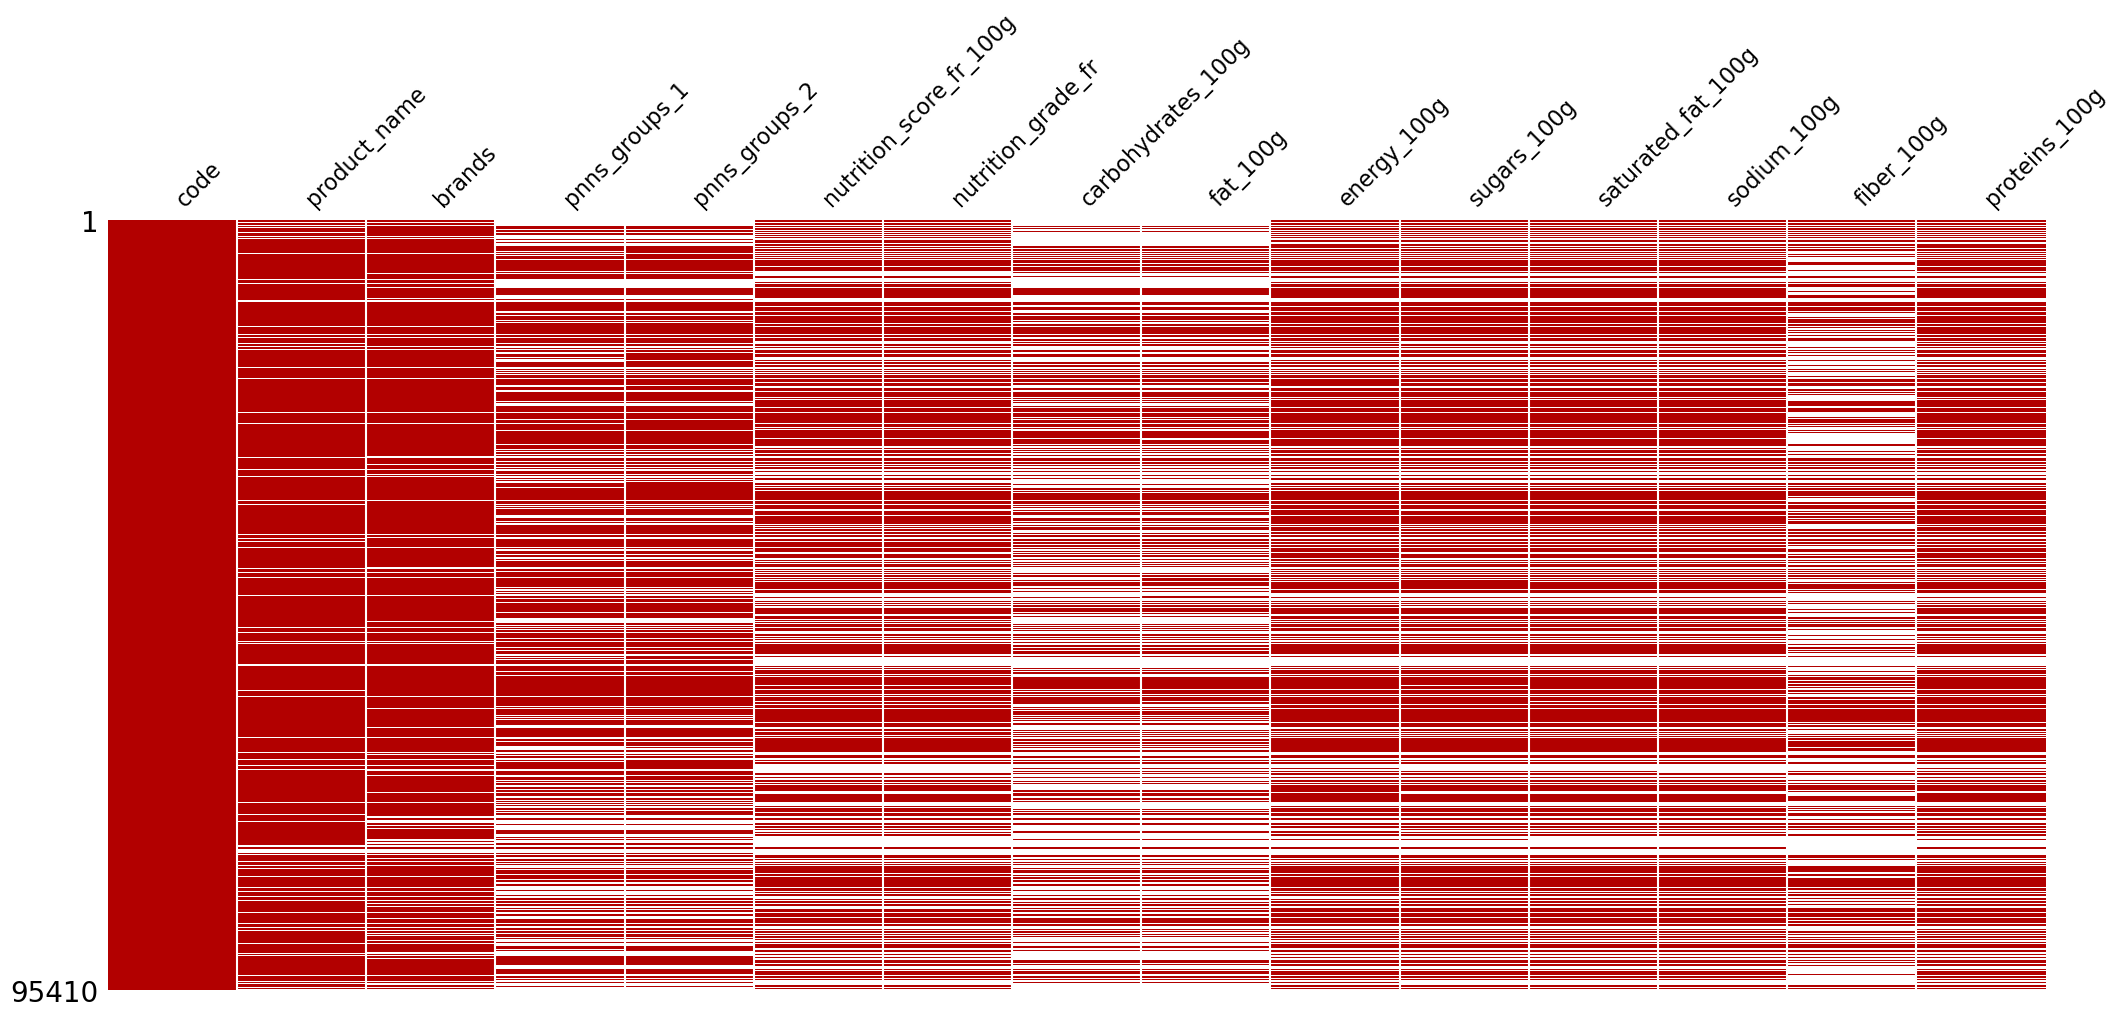

In [73]:
ms.matrix(foodClean07,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.show()

In [74]:
foodClean07.loc[foodClean07[numericalFeatureNames].isna().all(axis=1),numericalFeatureNames]

,nutrition_score_fr_100g,carbohydrates_100g,fat_100g,sugars_100g,saturated_fat_100g,fiber_100g,proteins_100g,sodium_100g,energy_100g
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
320758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Il est intéressant de remarquer que nos **features numériques sont simultanément vides sur plus de 30000 lignes**.
A prendre en compte pour le test.

Commençons par filtrer le dataframe :

In [75]:
foodCompleteFeaturesNames = foodClean07.columns.tolist()
foodCompleteFeaturesNames.remove("nutrition_grade_fr")
foodCompleteFeaturesNames.remove("code")
foodCompleteFeaturesNames.remove("product_name")
foodCompleteFeaturesNames.remove("brands")
foodCompleteFeaturesNames.remove("pnns_groups_1")

# scale "energy_100g" and "nutrition_score_fr_100g" to range (0,100), like others
zeroTo100Scaler=MinMaxScaler((0,100))
energyScaled=zeroTo100Scaler.fit_transform(foodClean07[["energy_100g"]])
nutritionScoreScaled=zeroTo100Scaler.fit_transform(foodClean07[["nutrition_score_fr_100g"]])

#create a dataframe with the non null rows of foodClean07

foodComplete = foodClean07[foodCompleteFeaturesNames].copy() # create a copy
foodComplete.energy_100g=energyScaled[:,0] # replace "energy_100g" with its scaled version
foodComplete.nutrition_score_fr_100g=nutritionScoreScaled[:,0] # replace "nutrition_score_fr_100g" with its scaled version
foodComplete=foodComplete.loc[foodComplete.notna().all(axis=1)] # keep non null rows only 

# list of numerical features names
foodCompleteNumFeaturesNames=foodComplete.select_dtypes("float64").columns.tolist()

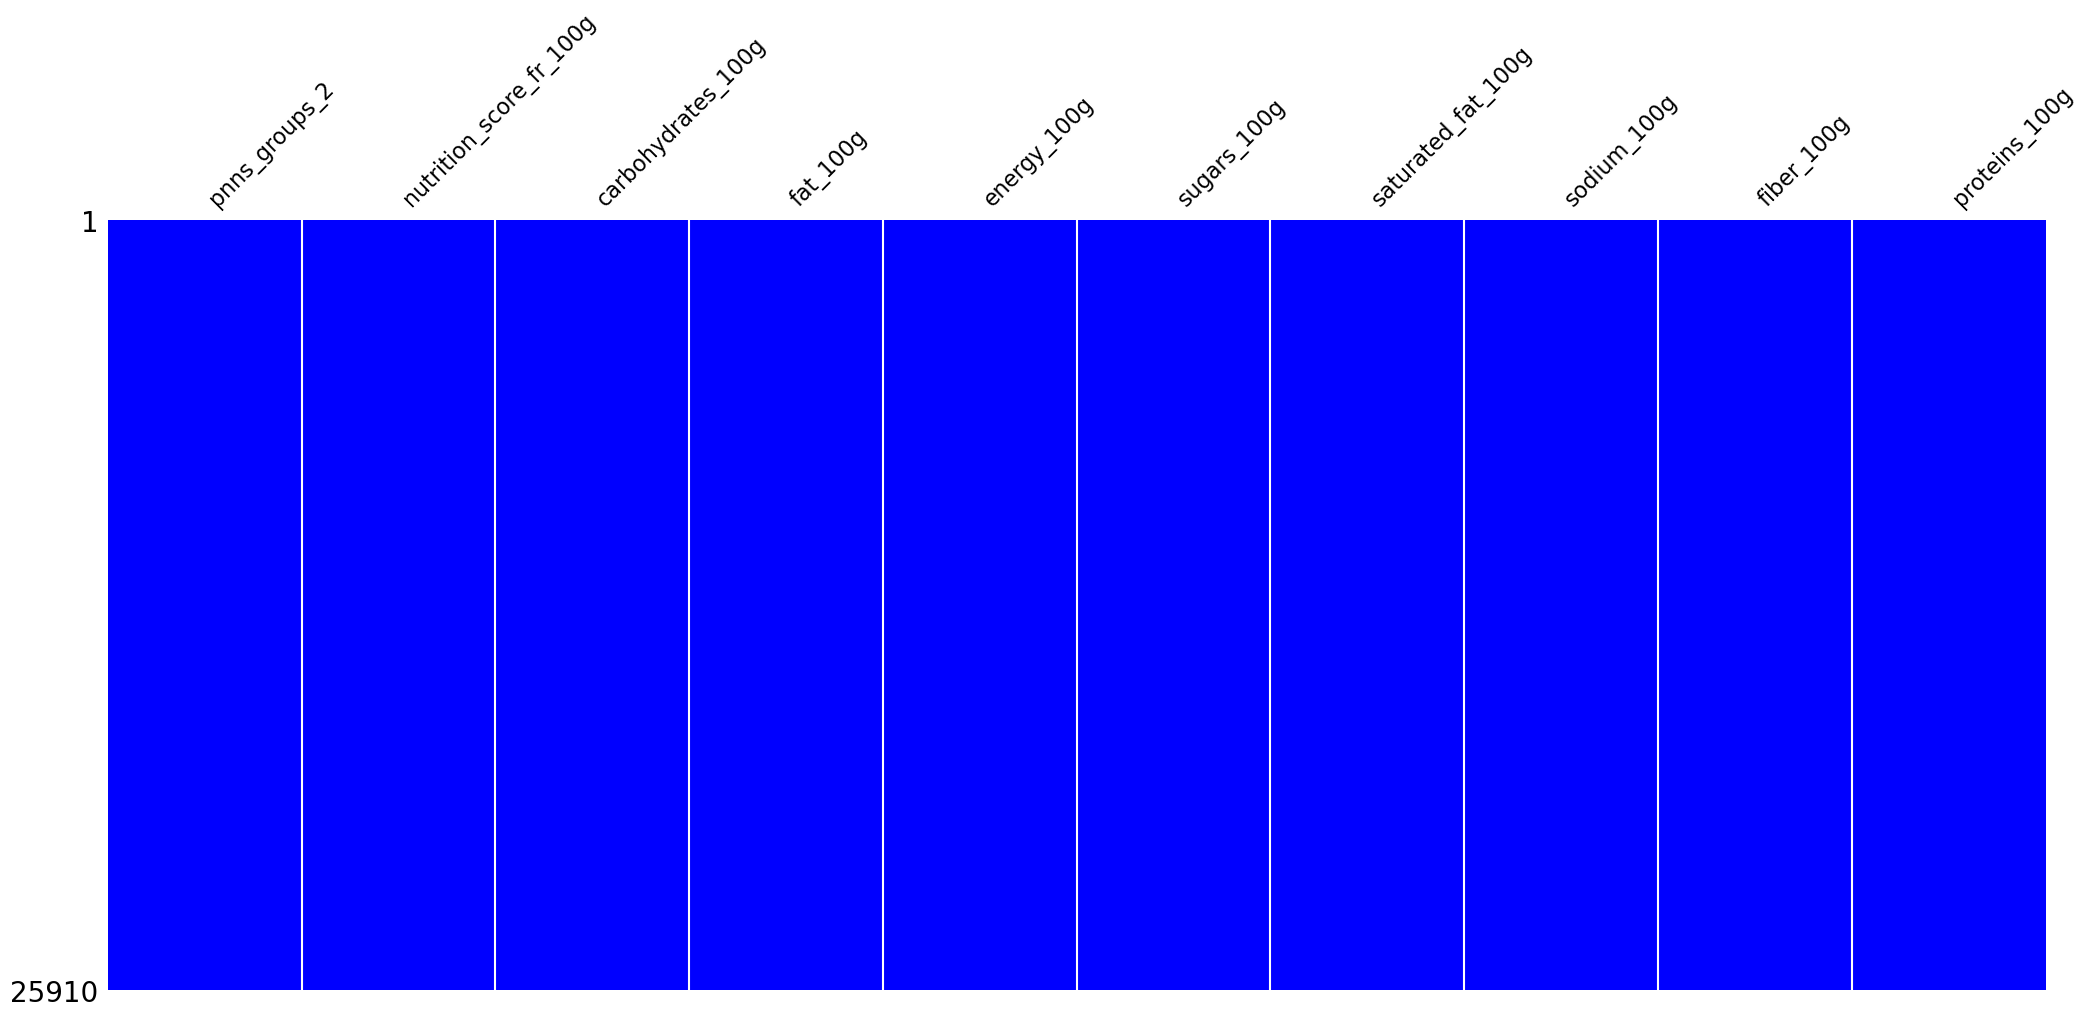

In [76]:
ms.matrix(foodComplete,color=[0.0,0.0,1],sparkline=False) # dataviz of missing data
plt.show()

Ensuite générons des valeurs manquantes :

In [77]:
# create null values

foodIncomplete = foodComplete.copy()
dictFoodIncompleteNanIndex = {} # initiate a dictionary to store missing values index for each feature

# first, generate nan values in all numerical rows with the same proportion than the orignal dataset
fracAllNum = foodClean07[foodCompleteNumFeaturesNames].isna().all(axis=1).mean() # get the proportion

indexsAllNum = foodComplete.sample(frac=fracAllNum).index # generate a sample and get its index

foodIncomplete.loc[indexsAllNum,foodCompleteNumFeaturesNames]=np.nan # generate the nan values in foodIncomplete


# then, generate random nan values in all columns
for col in foodComplete.columns :
    
    # get the rate of missing values for this column in the original dataframe
    if col in foodCompleteNumFeaturesNames :
        fracCol=foodClean07[col].isna().mean()-fracAllNum
    else :
        fracCol=foodClean07[col].isna().mean()
    
    indexsCol = foodIncomplete[col].notna().sample(frac=fracCol).index # generate a sample and get its index
    
    foodIncomplete.loc[indexsCol,col]=np.nan # generate the nan values in foodIncomplete[col]
        
    dictFoodIncompleteNanIndex[col]=foodIncomplete.loc[foodIncomplete[col].isna()].index # put the nan values index in its dict

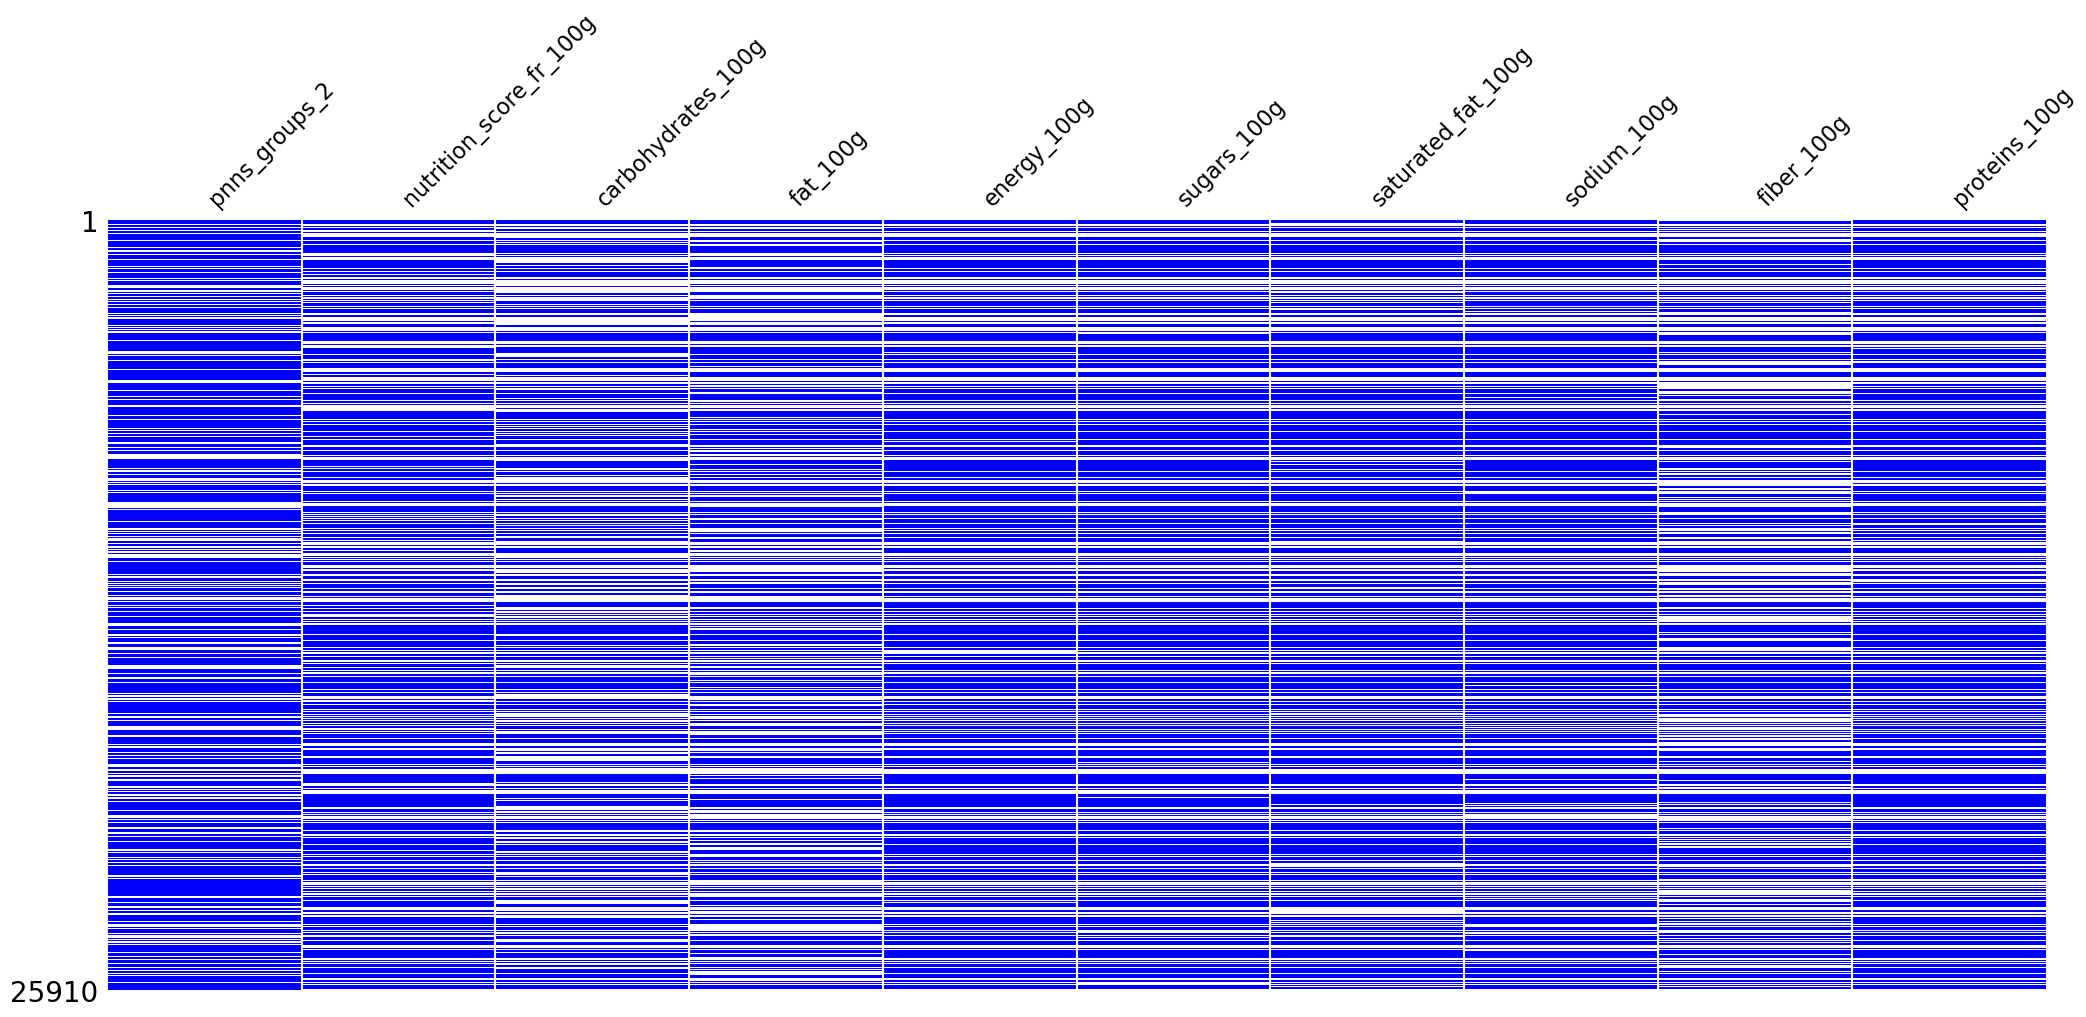

In [78]:
ms.matrix(foodIncomplete,color=[0.0,0.0,1],sparkline=False) # dataviz of missing data
plt.show()

### P2.4.3. Création de fonctions pour apprécier les résultats

Créons une première fonction qui nous permettra de comparer, pour une feature donnée, les résultats attendus dans une colonne, et les imputations réalisées dans une deuxième colonne :

In [79]:
# function to get in a dataframe the results of imputation for a specific feature

def getSoluceColAndGuessCol (col, dfComplete, dfIncomplete, dfGuess, nameOfTest=None) :
    
    ''' 
    generate a 2 columns dataframe with the results of imputation for a specific feature
    
    
    parameters
    ----------
    col : string, feature's name
    dfComplete : dataframe only with no missing values
    dfIncomplete : same dataframe, with missing values
    dfGuess : same dataframe, with the missing values imputed
    
    optional parameters
    -------------------
    nameOfTest : string, name of the imputation test
    
    returns
    -------
    
    SoluceAndGuessTab : dataframe with
        only original missing values indexes, 
        a column of expected values 
        a columns of imputed values
    '''
    
    # remove " " from nameOfTest
    if nameOfTest :
        nameOfTest=nameOfTest.replace(" ","_")
    
    # get missing values index
    colNanIndex = dfIncomplete.loc[dfIncomplete[col].isna()].index # get nan values index
    
    # create tab
    SoluceAndGuessTab = pd.DataFrame() # initiate dataframe
    SoluceAndGuessTab[col+"_SOLUCE_"+nameOfTest]=dfComplete.loc[colNanIndex,col] # create expected values column
    SoluceAndGuessTab[col+"_GUESS_"+nameOfTest]=dfGuess.loc[colNanIndex,col] # create imputed values column
    
    return SoluceAndGuessTab

Créons une seconde fonction pour nous donner des mesures du résultat d'une opération d'imputation. Pour chaque feature numérique on obtiendra :
- la racine de l'erreur quadratique moyenne (RMSE)

    *qui nous informe sur la distance moyenne qui sépare les valeurs imputées des valeurs attendues*
    
    
- le coefficient de détermination (R²)

    *qui nous informe sur le pourcentage de variation des valeurs attendues qui peut être expliquée par l'opération d'imputation*

In [80]:
def resultsNumImput(dfComplete, dfIncomplete, dfGuess, nameOfTest=None) :
    
    ''' 
    generate a 2 columns dataframe with r2 and Root Mean Squared Error for each numerical feature
    
    
    parameters
    ----------
    dfComplete : dataframe only with no missing values
    dfIncomplete : same dataframe, with missing values
    dfGuess : same dataframe, with the missing values imputed
    
    optional parameters
    -------------------
    nameOfTest : string, name of the imputation test
    
    returns
    -------
    resultTab : dataframe with
        numerical features in index 
        a column with RMSE 
        a column with R2
    '''
        
    # list of numerical features
    numFeaturesNames = dfComplete.select_dtypes("float64").columns.tolist()
    
    # remove " " from nameOfTest
    if nameOfTest :
        nameOfTest=nameOfTest.replace(" ","_")
        nameOfTest="_"+nameOfTest
    else :
        nameOfTest=""
    
    # initiate tab
    resultTab = pd.DataFrame(columns=['RMSE'+nameOfTest,'R2'+nameOfTest],index=numFeaturesNames,dtype="float64")
    
    # compute RMSE and R2 for each column
    for col in numFeaturesNames :
        
        colNanIndex = dfIncomplete.loc[dfIncomplete[col].isna()].index # get nan values index
        
        # get the columns
        soluceCol = dfComplete.loc[colNanIndex,col]
        guessCol  = dfGuess.loc[colNanIndex,col]
        
        # compute RMSE and R2, and put them in tab
        RMSECol = np.sqrt(mean_squared_error(soluceCol,guessCol))
        resultTab['RMSE'+nameOfTest].loc[col]=RMSECol
        
        R2Col = r2_score(soluceCol,guessCol)
        resultTab['R2'+nameOfTest].loc[col]=R2Col
        
    return resultTab

### P2.4.3. Tests sur la totalité du dataframe

#### P2.4.3.1. Global 5NN

Nous allons tout d'abord tester le KNN Imputeur sur la totalité de nos features numériques.

Essayons **au hasard avec k=5** :

In [81]:
# KNN pour les autres variables
KNN_imputer = KNNImputer(n_neighbors=5,missing_values=np.nan)
foodGuess01=pd.DataFrame(KNN_imputer.fit_transform(foodIncomplete[foodCompleteNumFeaturesNames]),columns=foodCompleteNumFeaturesNames,index=foodIncomplete.index)

Regardons à quoi ressemble une des features, au hasard "sugars_100g", au niveau des lignes imputées :

In [82]:
foodIncomplete.fat_100g

106       20.0
226        NaN
452        NaN
454       29.1
458        NaN
          ... 
320670     2.1
320681     1.3
320702     NaN
320751     NaN
320763     0.2
Name: fat_100g, Length: 25910, dtype: float64

In [83]:
getSoluceColAndGuessCol (
    col="fat_100g", 
    dfComplete=foodComplete, 
    dfIncomplete=foodIncomplete, 
    dfGuess=foodGuess01, 
    nameOfTest="Global 5NN"
).sample(15)

,fat_100g_SOLUCE_Global_5NN,fat_100g_GUESS_Global_5NN
209587,3.4,11.594829
188479,4.3,4.820000
259242,1.1,11.594829
192582,0.5,0.360000
192814,3.9,11.594829
222913,1.5,11.594829
317613,21.3,11.594829
208078,3.5,11.594829
237877,0.1,1.060000
239385,23.0,11.594829


Cela n'a pas l'air très concluant, regardons ce que cela donne pour les RMSEs et R2s de chaque feature numérique :

In [84]:
foodGuess_mesures=resultsNumImput(
    dfComplete=foodComplete, 
    dfIncomplete=foodIncomplete, 
    dfGuess=foodGuess01, 
    nameOfTest="Global 5NN"
)
foodGuess_mesures

,RMSE_Global_5NN,R2_Global_5NN
nutrition_score_fr_100g,15.765366,0.059336
carbohydrates_100g,23.623122,0.248015
fat_100g,12.693658,0.262002
energy_100g,20.282972,0.013117
sugars_100g,16.709298,0.051032
saturated_fat_100g,6.702221,0.059536
sodium_100g,1.436639,0.002575
fiber_100g,3.561286,0.167007
proteins_100g,6.528053,0.014287


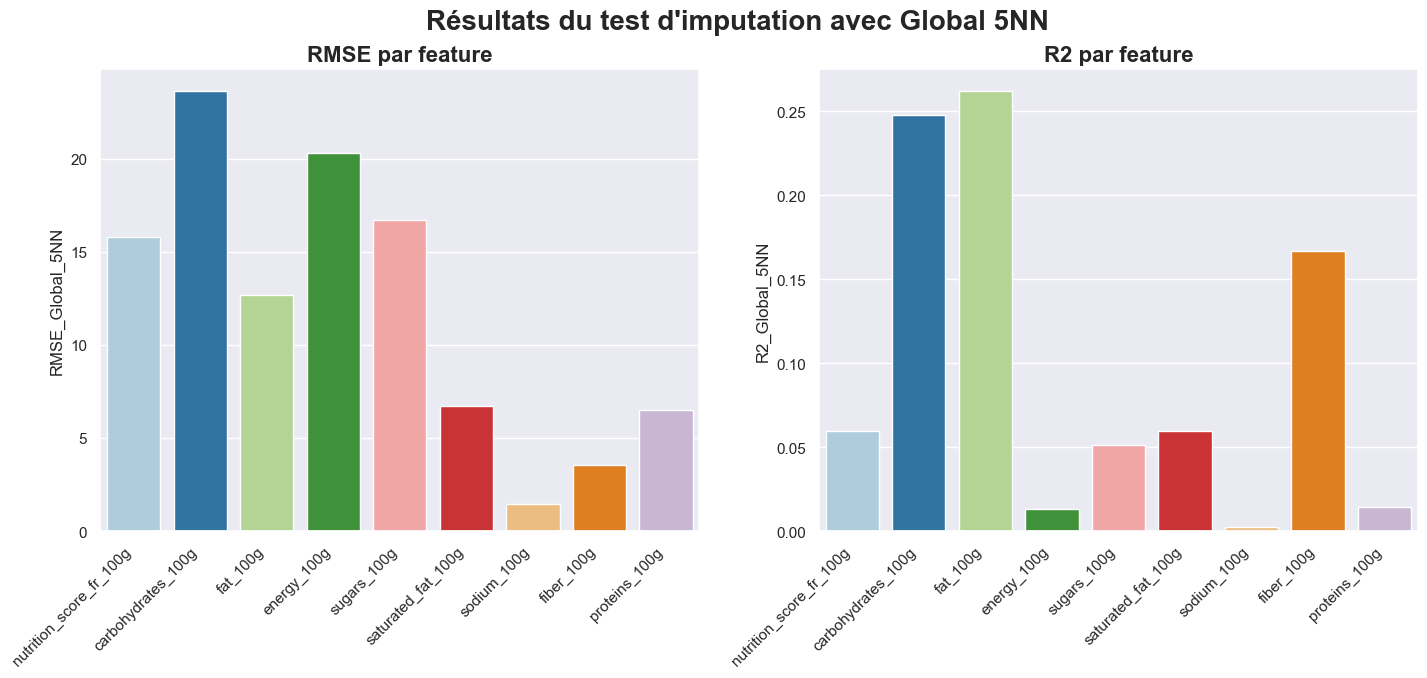

In [183]:

fig,axs=plt.subplots(1,2,sharex=True,figsize=(17,6)) # 2 plots 

palette=sns.color_palette("Paired") # set color palette
sns.set_palette("Paired")

xlabels=foodGuess_mesures.index

sns.barplot(data=foodGuess_mesures,y="RMSE_Global_5NN",x=xlabels,ax=axs[0])
sns.barplot(data=foodGuess_mesures,y="R2_Global_5NN",x=xlabels,ax=axs[1])

fig.suptitle("Résultats du test d'imputation avec Global 5NN", fontweight="bold",fontsize=20)
axs[0].set_title("RMSE par feature", fontweight="bold",fontsize=16) 
axs[1].set_title("R2 par feature", fontweight="bold",fontsize=16) 

axs[0].set_xticklabels(xlabels,rotation=45,ha="right")
axs[1].set_xticklabels(xlabels,rotation=45,ha="right")

plt.show()

#### P2.4.3.2. Global BestNN

Essayons d'optimiser k. Pour cela nous allons créer une fonction qui va :
- itérer sur une fourchette de k donnée
- nous donner en sortie :
    - un tableau avec pour chaque feature numérique, et chaque valeur de k, le RMSE. Ainsi que le meilleur k (celui qui donne le plus petit RMSE).
    - un tableau avec pour chaque feature numérique, et chaque valeur de k, le R2. Ainsi que le meilleur k (celui qui donne le plus grand coefficient de détermination R2).
    - un tableau avec la moyenne des RMSEs et R2s, pour chaque valeur de k. Ainsi que le meilleur k en considérant ces moyennes.

In [85]:
def BestKNNImputer(dfComplete, dfIncomplete, rangeOfK=(2,10)) :
    
    ''' 
    generate a 2 columns dataframe with r2 and Root Mean Squared Error for each numerical feature
    
    
    parameters
    ----------
    dfComplete : dataframe only with no missing values
    dfIncomplete : same dataframe, with missing values
    dfGuess : same dataframe, with the missing values imputed
    
    optional parameters
    -------------------
    nameOfTest : string, name of the imputation test
    
    returns
    -------
    resultTab : dataframe with
        numerical features in index 
        a column with RMSE 
        a column with R2
    '''
    
    # list of numerical features
    numFeaturesNames = dfComplete.select_dtypes("float64").columns.tolist()
    
    # create dataframes to store the mesures for each k
    resultTabRMSE=pd.DataFrame(index=numFeaturesNames,dtype="float64")
    resultTabR2=pd.DataFrame(index=numFeaturesNames,dtype="float64")
    
    # create a dataframe to store the mean of RMSEs and the mean of R2s for each k
    resultTabGlobal=pd.DataFrame(columns=["k="+str(i) for i in range(rangeOfK[0],rangeOfK[1])], index=["Mean_of_RMSEs","Mean_of_R2s"],dtype="float64")
    
    for k in range(rangeOfK[0],rangeOfK[1]) :
        
        KNN_imputer=KNNImputer(n_neighbors=k,missing_values=np.nan) # initiate knn imputer for this k
        
        # generate a dfGuess
        dfGuessK=pd.DataFrame(
            KNN_imputer.fit_transform(dfIncomplete[numFeaturesNames]), # fit transform
            columns=numFeaturesNames,
            index=dfIncomplete.index
        )
        
        # use previous function and generate a resultsNumImput(dfComplete, dfIncomplete, dfGuess, nameOfTest=xxx) :
        resultTabK=resultsNumImput(
            dfComplete=dfComplete, 
            dfIncomplete=dfIncomplete, 
            dfGuess=dfGuessK, 
            nameOfTest="k="+str(k)
        )
        
        # put in the main tabs
        resultTabRMSE["RMSE"+"_"+"k="+str(k)]=resultTabK["RMSE"+"_"+"k="+str(k)]
        resultTabR2["R2"+"_"+"k="+str(k)]=resultTabK["R2"+"_"+"k="+str(k)]
        
        # put means in their tab
#         resultTabGlobal["Mean_of_RMSEs"].loc["k="+str(k)]=resultTabK["RMSE"+"_"+"k="+str(k)].mean()
#         resultTabGlobal["Mean_of_R2s"].loc["k="+str(k)]=resultTabK["R2"+"_"+"k="+str(k)].mean()
        
        resultTabGlobal["k="+str(k)].loc["Mean_of_RMSEs"]=resultTabK["RMSE"+"_"+"k="+str(k)].mean()
        resultTabGlobal["k="+str(k)].loc["Mean_of_R2s"]=resultTabK["R2"+"_"+"k="+str(k)].mean()
    
    # give for each numerical feature the k with best RMSE and R2
    resultTabRMSE["best_k_per_feature"]=resultTabRMSE.idxmin(axis=1).str.split("=").str[-1]
    resultTabR2["best_k_per_feature"]=resultTabR2.idxmax(axis=1).str.split("=").str[-1]
    
    # give, globally, for Mean_of_RMSEs and for Mean_of_R2s, the best k
    resultTabGlobal.loc["Mean_of_RMSEs","best_k_on_average"]=resultTabGlobal.loc["Mean_of_RMSEs"].idxmin(axis=0).split("=")[-1]
    resultTabGlobal.loc["Mean_of_R2s","best_k_on_average"]=resultTabGlobal.loc["Mean_of_R2s"].astype("float64").idxmax(axis=0).split("=")[-1]
  
    return resultTabRMSE,resultTabR2,resultTabGlobal

Regardons l'impact de k sur la précision de l'imputation, pour **k de 2 à 9** :

In [86]:
tabRMSE,tabR2,tabMean = BestKNNImputer(
    dfComplete=foodComplete, 
    dfIncomplete=foodIncomplete, 
    rangeOfK=(2,10)
)

In [87]:
display(tabRMSE,tabR2,tabMean)

,RMSE_k=2,RMSE_k=3,RMSE_k=4,RMSE_k=5,RMSE_k=6,RMSE_k=7,RMSE_k=8,RMSE_k=9,best_k_per_feature
nutrition_score_fr_100g,15.782790,15.771509,15.767765,15.765366,15.763360,15.759991,15.759441,15.759369,9
carbohydrates_100g,23.678952,23.654487,23.634066,23.623122,23.605090,23.597389,23.597099,23.588058,9
fat_100g,12.708247,12.704846,12.696319,12.693658,12.689003,12.689925,12.687372,12.687197,9
energy_100g,20.292834,20.287146,20.282640,20.282972,20.282401,20.282864,20.281900,20.281495,9
sugars_100g,16.733623,16.724709,16.715241,16.709298,16.708512,16.708365,16.708328,16.707660,9
saturated_fat_100g,6.704243,6.703491,6.702500,6.702221,6.705245,6.704887,6.701943,6.701147,9
sodium_100g,1.436576,1.436170,1.436527,1.436639,1.436488,1.436520,1.436358,1.436377,3
fiber_100g,3.559229,3.565276,3.566916,3.561286,3.564058,3.566677,3.562489,3.563157,2
proteins_100g,6.537426,6.532185,6.529275,6.528053,6.527363,6.526297,6.525561,6.526360,8


,R2_k=2,R2_k=3,R2_k=4,R2_k=5,R2_k=6,R2_k=7,R2_k=8,R2_k=9,best_k_per_feature
nutrition_score_fr_100g,0.057255,0.058603,0.059050,0.059336,0.059575,0.059977,0.060043,0.060051,9
carbohydrates_100g,0.244456,0.246017,0.247318,0.248015,0.249162,0.249652,0.249671,0.250246,9
fat_100g,0.260305,0.260701,0.261693,0.262002,0.262544,0.262436,0.262733,0.262753,9
energy_100g,0.012157,0.012711,0.013150,0.013117,0.013173,0.013128,0.013221,0.013261,9
sugars_100g,0.048267,0.049280,0.050356,0.051032,0.051121,0.051138,0.051142,0.051218,9
saturated_fat_100g,0.058968,0.059179,0.059457,0.059536,0.058687,0.058787,0.059614,0.059837,9
sodium_100g,0.002663,0.003226,0.002730,0.002575,0.002785,0.002741,0.002965,0.002939,3
fiber_100g,0.167969,0.165139,0.164371,0.167007,0.165709,0.164483,0.166444,0.166131,2
proteins_100g,0.011455,0.013039,0.013918,0.014287,0.014495,0.014817,0.015039,0.014798,8


,k=2,k=3,k=4,k=5,k=6,k=7,k=8,k=9,best_k_on_average
Mean_of_RMSEs,11.937102,11.931091,11.925694,11.922513,11.920169,11.919213,11.917832,11.916758,9
Mean_of_R2s,0.095944,0.096433,0.096894,0.097434,0.097472,0.097462,0.097875,0.097915,9


On voit que modifier k n'a pas beaucoup d'impact sur la précision de l'imputation. De plus le temps de calcul est **très long**.

On peut expliquer tenter d'expliquer la faible performance :
- on a utilisé le KNN Imputer sur l'ensemble des features numériques en même temps, **sans nous soucier des correlations en elles**
- on a utilisé le KNN Impiter sur l'ensemble des lignes en même temps. Or la [documentation](https://scikit-learn.org/stable/modules/impute.html) de scikit-learn précise bien que, lors de l'imputation d'une feature donnée, pour les lignes avec moins de valeurs non null disponibles que k, l'Imputer **impute avec la moyenne de la feature**. 

    C'est **typiquement le cas sur nos lignes où la totalité des valeurs numériques sont manquantes ...**

Vérifions cela sur notre test avec k=5 :

In [88]:
foodGuess01.loc[foodIncomplete.isna().all(axis=1)].sample(3)

,nutrition_score_fr_100g,carbohydrates_100g,fat_100g,energy_100g,sugars_100g,saturated_fat_100g,sodium_100g,fiber_100g,proteins_100g
191043,39.144757,30.820703,11.594829,29.453254,12.617229,4.431948,0.345269,2.809877,7.087619
220087,39.144757,30.820703,11.594829,29.453254,12.617229,4.431948,0.345269,2.809877,7.087619
243471,39.144757,30.820703,11.594829,29.453254,12.617229,4.431948,0.345269,2.809877,7.087619


#### P2.4.3.3. Global Iterative Imputer

Essayons l'Iterative Imputer :

In [89]:
# iterative imputeur on all numerical features
from sklearn.linear_model import LinearRegression
iterative_imputer = IterativeImputer(estimator=LinearRegression())
foodGuess02=pd.DataFrame(iterative_imputer.fit_transform(foodIncomplete[foodCompleteNumFeaturesNames]),columns=foodCompleteNumFeaturesNames,index=foodIncomplete.index)

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [90]:
# add the results of foodGuess03 to foodGuess_mesures
foodGuess_mesures=pd.concat(
    [foodGuess_mesures,
     resultsNumImput(
         dfComplete=foodComplete, 
         dfIncomplete=foodIncomplete, 
         dfGuess=foodGuess02, 
         nameOfTest="Global Iterative"
     )
    ],
    axis=1
)
foodGuess_mesures

,RMSE_Global_5NN,R2_Global_5NN,RMSE_Global_Iterative,R2_Global_Iterative
nutrition_score_fr_100g,15.765366,0.059336,15.860483,0.047951
carbohydrates_100g,23.623122,0.248015,23.824837,0.235118
fat_100g,12.693658,0.262002,12.803827,0.249137
energy_100g,20.282972,0.013117,20.280049,0.013402
sugars_100g,16.709298,0.051032,16.851764,0.034781
saturated_fat_100g,6.702221,0.059536,6.752702,0.045315
sodium_100g,1.436639,0.002575,1.435540,0.004101
fiber_100g,3.561286,0.167007,3.759701,0.071602
proteins_100g,6.528053,0.014287,6.534583,0.012314


Nous n'obtenons pas de meilleurs résultats...

Cela peut s'expliquer : 
- l'IterativeImputer impute en réalisant une regression (ici, linéaire) de **chaque feature en fonction de TOUTES les autres, à tour de rôle**. Or toutes nos features **ne sont pas correlés entre elles**...
- nous retrouvons le même problème que pour le KNN Imputer avec les lignes vides :


In [91]:
foodGuess02.loc[foodIncomplete.isna().all(axis=1)].sample(3)

,nutrition_score_fr_100g,carbohydrates_100g,fat_100g,energy_100g,sugars_100g,saturated_fat_100g,sodium_100g,fiber_100g,proteins_100g
208674,39.138317,30.957916,11.610084,29.449289,12.623508,4.430297,0.345909,2.80802,7.090223
187486,39.138317,30.957916,11.610084,29.449289,12.623508,4.430297,0.345909,2.80802,7.090223
319571,39.138317,30.957916,11.610084,29.449289,12.623508,4.430297,0.345909,2.80802,7.090223




**Une solution pour améliorer nos imputations serait de :**
- dans un premier temps : **séparer le dataframe `foodIncomplete` en deux AVANT d'utiliser un imputer**, avec :
    - d'un côté les **lignes pour lesquelles les valeurs numériques sont toutes manquantes** :
        - imputer chaque feature de ce dataframe avec une méthode un peu plus précise qu'une imputation par la moyenne de la feature de `foodIncomplete` : Par exemple en utilisant la variable catégorielle "pnns_2" et en **imputant différemment pour chacune de ses modalités**.
        - (**on pourrait tout aussi bien faire le choix de se séparer de ces lignes pour notre nettoyage final... Mais cela reviendrait à nous séparer de beaucoup de produits...**)
    - d'un autre côté **les lignes pour lesquelles on a au moins une valeurs non manquante** :
        - observer les correlations entre features et utiliser les imputeurs par groupe de features.

### P2.4.4. Améliorer nos imputation

#### P2.4.4.1. Séparer le dataframe `foodIncomplete` : lignes numériques 100% vides / les autres

In [92]:
numFeaturesNames = foodIncomplete.select_dtypes("float64").columns.tolist()

foodIncompleteEmpty=foodIncomplete.copy()
foodIncompleteOthers=foodIncomplete.copy()

foodIncompleteEmpty=foodIncompleteEmpty.loc[foodIncompleteEmpty[numFeaturesNames].isna().all(axis=1)]
foodIncompleteOthers=foodIncompleteOthers.loc[foodIncompleteOthers[numFeaturesNames].notna().any(axis=1)]

In [93]:
foodIncomplete.shape

(25910, 10)

In [94]:
foodIncompleteEmpty.shape

(8845, 10)

In [95]:
foodIncompleteOthers.shape

(17065, 10)

## P2.4. Traiter les valeurs manquantes - features numériques

### P2.4.1. Matrice des correlations

In [96]:
# Compute the correlation matrix
foodCorr=foodClean07.loc[~foodClean07.isna().all(axis=1)].corr()
foodCorr

,nutrition_score_fr_100g,carbohydrates_100g,fat_100g,energy_100g,sugars_100g,saturated_fat_100g,sodium_100g,fiber_100g,proteins_100g
nutrition_score_fr_100g,1.000000,0.243538,0.579531,0.625728,0.451424,0.603513,0.123968,-0.127557,0.097078
carbohydrates_100g,0.243538,1.000000,-0.071361,0.527415,0.636864,-0.024774,-0.085038,0.250487,-0.131873
fat_100g,0.579531,-0.071361,1.000000,0.782006,0.005597,0.744111,0.010039,0.081547,0.145883
energy_100g,0.625728,0.527415,0.782006,1.000000,0.327639,0.572878,-0.023853,0.210181,0.209382
sugars_100g,0.451424,0.636864,0.005597,0.327639,1.000000,0.080296,-0.095226,0.034818,-0.249965
saturated_fat_100g,0.603513,-0.024774,0.744111,0.572878,0.080296,1.000000,0.002155,0.019908,0.143507
sodium_100g,0.123968,-0.085038,0.010039,-0.023853,-0.095226,0.002155,1.000000,-0.014963,0.092568
fiber_100g,-0.127557,0.250487,0.081547,0.210181,0.034818,0.019908,-0.014963,1.000000,0.197247
proteins_100g,0.097078,-0.131873,0.145883,0.209382,-0.249965,0.143507,0.092568,0.197247,1.000000


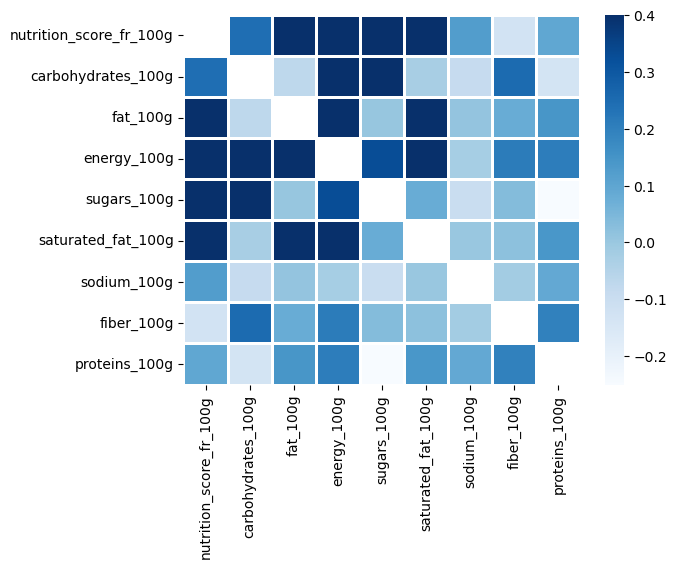

In [97]:
# Display the correlation matrix on a heatmap

# Generate a mask to display only the lower triangle
maskTri = np.triu(np.ones_like(foodCorr, dtype=bool),k=1)
maskId = np.identity(len(foodCorr),dtype=bool)

# Draw the heatmap with the mask

sns.heatmap(
    data=foodCorr,
    mask=maskId,
    linewidth=1,
    cmap="Blues",
    vmax=0.4
    
);


**Le score nutritionnel étant la feature que l'application devra prédire pour calculer un MyHealthScore, nous n'allons pas réaliser d'opération d'imputation dessus. La préparation des données, objet du présent projet, pourra permettre d'alimenter les personnes en charge de la création de l'app.**

**Nous pouvons néanmoins nous en servir pour imputer les autres features.**

### P2.4.2. Deux groupes


### P2.4.3. Groupe 1 - les variables assez corrélées entre elles


In [98]:
group1Features = ["nutrition"]

#### P2.4.3.1. Groupe 1 - création d'un échantillon de test


#### P2.4.3.2. Groupe 1 - test du iterative imputer


#### P2.4.3.3. Groupe 1 - test du KNN imputer


#### P2.4.3.4. Groupe 1 - test du simple imputer mixé avec pnns-2


#### P2.4.3.5. Groupe 1 - comparaison des résultats


#### P2.4.3.5. Groupe 1 - imputation


### P2.4.4. Groupe 2 - les variables peu corrélées entre elles


#### P2.4.4.1. Groupe 2 - création d'un échantillon de test


#### P2.4.4.2. Groupe 2 - test du iterative imputer


#### P2.4.4.3. Groupe 2 - test du KNN imputer


#### P2.4.4.4. Groupe 2 - test du simple imputer mixé avec pnns-2


#### P2.4.4.5. Groupe 2 - comparaison des résultats


#### P2.4.4.5. Groupe 2 - imputation


# Partie 3 - Exploration

# Tests -  score nutritionnel et nutrigrade

In [99]:
testNutri=foodClean02[["nutrition_grade_fr","nutrition_score_fr_100g"]].copy()
testNutri=testNutri.loc[testNutri.notna().any(axis=1)]
testNutri=testNutri.sort_values("nutrition_grade_fr")

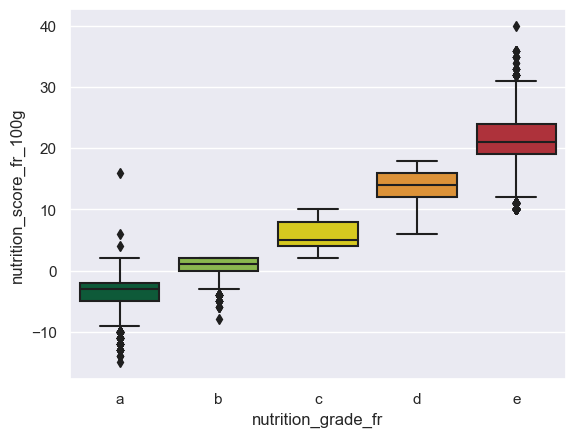

In [100]:
sns.set(style="darkgrid")
myPalette= {"a": "#02663B",
           "b": "#8DC83E",
           "c" : "#F4E300",
           "d" : "#F7941D",
           "e" : "#C31D2A",
           }
sns.boxplot(data=testNutri,x="nutrition_grade_fr",y="nutrition_score_fr_100g",palette=myPalette);

# Tests -  énergie et nutrigrade

In [101]:
testEnerNut=foodClean02[["nutrition_grade_fr","energy_100g"]].copy()

In [102]:
testEnerNut=testEnerNut.loc[testEnerNut.notna().any(axis=1)]
testEnerNut=testEnerNut.loc[testEnerNut["energy_100g"]<3700]
testEnerNut=testEnerNut.sort_values("nutrition_grade_fr")

<AxesSubplot:xlabel='nutrition_grade_fr', ylabel='energy_100g'>

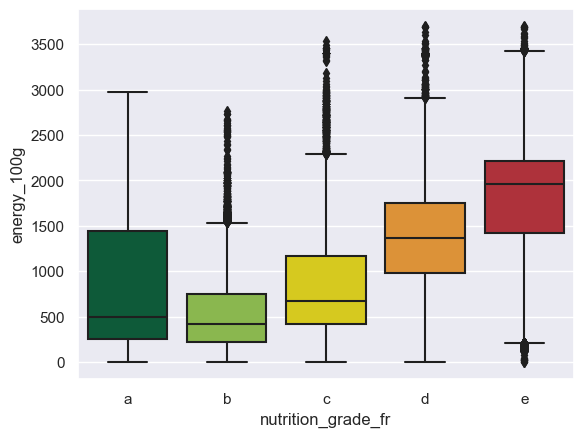

In [103]:
sns.boxplot(data=testEnerNut,x="nutrition_grade_fr",y="energy_100g",palette=myPalette)

# Tests -  énergie et nutrigrade

In [104]:
foodRaw.pnns_groups_2.value_counts()

unknown                             22624
One-dish meals                       5546
Sweets                               4698
Biscuits and cakes                   4561
Non-sugared beverages                4302
Cereals                              4106
Cheese                               4024
Dressings and sauces                 3602
Milk and yogurt                      3297
Processed meat                       3247
Chocolate products                   3109
Alcoholic beverages                  2909
Vegetables                           2840
Fish and seafood                     2638
Sweetened beverages                  2170
Appetizers                           2101
Fruits                               2068
Fruit juices                         1924
Bread                                1838
Meat                                 1694
Fats                                 1614
Breakfast cereals                    1408
vegetables                            934
Legumes                           

In [105]:
%pwd

'C:\\Users\\cleme\\OneDrive\\Documents\\8. TRAVAIL CLEMENT\\2.3. Reconversion Data\\1. OpenClassRooms\\2. Projets\\2.3. Préparez données pour organisme santé publique'